# Improving Generalization in Neuron-to-Gaze Decoding for Brain-Computer Interfaces
### Kendra K. Noneman and J. Patrick Mayo

In [1]:
DATA_FOLDER =  '/Users/kendranoneman/Projects/mayo/NeuralDecoding/runs_neurips'
FIG_FOLDER  =  '/Users/kendranoneman/Posters/NeurIPS-2024/'
#FIG_FOLDER  =  '/Users/kendranoneman/Figures/neural-decoding/final_manuscript/pdf_versions'

## Packages and functions

In [35]:
# Packages and toolboxes
import numpy as np
import pandas as pd
import os
import sys
import pickle
import cmath
import math

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import TwoSlopeNorm, LinearSegmentedColormap
%matplotlib inline

from scipy import io, stats
from scipy.stats import mannwhitneyu, normaltest, zscore, wilcoxon, ttest_rel

# Colors for each decoding model
cols = ['#317c32','#20a693','#358eb9','#3127d7','#a624d7','#d51f89']
cols = [mcolors.to_rgb(col) for col in cols]

grays = ['#c1d7c1','#bce4de','#c2ddea','#c1bef3','#e4bdf3','#f2bbdb']
grays = [mcolors.to_rgb(col) for col in grays]

pal_cols = ['#00B315','#00B377','#008CB3','#002DB3','#3C00B3','#8C00B3']
pals = [sns.light_palette(col, as_cmap=True, n_colors=15) for col in cols]

In [3]:
example_data = io.loadmat('/Users/kendranoneman/Projects/mayo/NeuralDecoding/datasets/vars/vars-pa29dir4A-pre500-post300.mat')
out_times    =  np.squeeze(example_data['vels_times']) # times at which velocities were recorded
sess_size = len(out_times)

In [4]:
# Functions for concatenating pickle files and calculating evaluation metrics
def get_outputs_wTraces(data_folder,conditions,column_names):
    """ 
    Function to get results for each decoder run, concatenated across models, repeats, etc...

    Parameters
    ----------
    data_folder  - path to the folder where data is located 
    conditions   - array of strings, containing labels for conditions you wish to include in data extraction
    column_names - names of columns for data you are pulling out, this varied a little across analyses

    Returns
    -------
    df            - pandas dataframe containing all of the evaluation metrics and labels for each decoder run
    conds_all     - labels for each observation in the test set, including trial conditions and markers
    yTest_all     - actual/recorded eye traces from test set
    yTestPred_all - predicted/decoded eye traces from test set 
    """
    results_all,conds_all,yTest_all,yTestPred_all = [],[],[],[]
    direcs = sorted(os.listdir(data_folder))
    current_direcs = [d for d in direcs if all(c in d for c in conditions)]
    for direc in current_direcs:
        files = sorted(os.listdir(os.path.join(data_folder, direc)))
        for file in files:
            file_path = os.path.join(data_folder, direc, file)
            if os.path.exists(file_path) and os.path.getsize(file_path) > 0:
                if file.endswith('.pickle') and ('repeat000.' in file or 'repeat00.' in file):
                    with open(file_path, 'rb') as f:
                        results,conds,y_test,y_test_predicted = pickle.load(f)
                        conds_all.append(conds)
                        results_all.append(results)
                        yTest_all.append(y_test)
                        yTestPred_all.append(y_test_predicted)
                elif file.endswith('.pickle'):
                    with open(file_path, 'rb') as f:
                        results = pickle.load(f)
                        results_all.append(results[0])

    df = pd.DataFrame(results_all,columns=column_names)
    df['R2_x']   = df['R2'].apply(lambda x: x[0])
    df['R2_y']   = df['R2'].apply(lambda x: x[1])
    df['R2_mn']  = df['R2'].apply(lambda x: x.mean())
    df['rho_mn']  = df['rho'].apply(lambda x: x.mean())
    df['R2sh_mn']  = df['R2_shuf'].apply(lambda x: x.mean())
    df['R2tr_mn']  = df['R2_train'].apply(lambda x: x.mean())
    
    return df,conds_all,yTest_all,yTestPred_all

def get_outputs(data_folder, conditions, column_names, lrange=[0,10000], withTraces=False):
    """ 
    Function to get results for each decoder run, concatenated across models, repeats, etc...

    Parameters
    ----------
    data_folder  - path to the folder where data is located 
    conditions   - array of strings, containing labels for conditions you wish to include in data extraction
    column_names - names of columns for data you are pulling out, this varied a little across analyses

    Returns
    -------
    df            - pandas dataframe containing all of the evaluation metrics and labels for each decoder run
    yTestPred_all - predicted/decoded eye traces from test set 
    """
    results_all, yp_test_all = [], []

    # Get sorted list of directories in data_folder
    direcs = sorted(os.listdir(data_folder))
    
    def extract_number(direc_name):
        """Extract the first number from the directory name."""
        parts = direc_name.split('-')
        if parts and parts[0].isdigit():
            return int(parts[0])
        return None

    # Filter directories based on conditions and number range
    current_direcs = [
        d for d in direcs 
        if all(c in d for c in conditions) and extract_number(d) is not None and lrange[0] <= extract_number(d) <= lrange[1]
    ]

    # Filter directories based on conditions
    #current_direcs = [d for d in direcs if all(c in d for c in conditions)]

    # Iterate over filtered directories
    for direc in current_direcs:
        files = sorted(os.listdir(os.path.join(data_folder, direc)))
        for file in files:
            file_path = os.path.join(data_folder, direc, file)
            # Check if file exists and is non-empty
            if os.path.exists(file_path) and os.path.getsize(file_path) > 0:
                with open(file_path, 'rb') as f:  
                    if withTraces is True:
                        # Load data from file
                        results, yp_test = pickle.load(f)
                        # Append to lists
                        results_all.append(results)
                        #yp_train_all.append(yp_train)
                        yp_test_all.append(yp_test)
                    else:
                        # Load data from file
                        results, _ = pickle.load(f)
                        # Append to lists
                        results_all.append(results)
                        yp_test_all = 0

    # Create DataFrame from results_all list
    df = pd.DataFrame(results_all, columns=column_names)
    
    df['R2_test_mn']  = df['R2_test'].apply(lambda x: x.mean())
    df['rho_test_mn']  = df['rho_test'].apply(lambda x: x.mean())
    df['rmse_test_mn']  = df['rmse_test'].apply(lambda x: x.mean())
    df['R2_train_mn']  = df['R2_train'].apply(lambda x: x.mean())
    df['rho_train_mn']  = df['rho_train'].apply(lambda x: x.mean())
    df['rmse_train_mn']  = df['rmse_train'].apply(lambda x: x.mean())

    return df, yp_test_all

def get_actualTraces(data_folder, df):
    output_mapping = {"position": 0, "velocity": 1, "acceleration": 2}
    
    y_test_all,c_test_all = [],[]
    # Iterate over rows and format string
    for index, row in df.iterrows():
        file = "actual-s{:02d}-t{:01d}-dto{:03d}-df{:01d}-o{:d}-fold{:0>1d}.pickle".format(
            row["sess"], 
            row["timePrePost"], 
            row["output_binWidth"], 
            row["downsample_factor"], 
            output_mapping.get(row["output"], None), 
            row["outer_fold"])
        
        file_path = os.path.join(data_folder, 'actual/', file)
        with open(file_path, 'rb') as f:
            # Load data from file
            y_test, c_test = pickle.load(f)
            # Append to lists
            #y_train_all.append(y_train)
            #c_train_all.append(c_train)
            y_test_all.append(y_test)
            c_test_all.append(c_test)

    return y_test_all, c_test_all

def get_R2(y_test,y_test_pred):

    """
    Function to get R2

    Parameters
    ----------
    y_test - the true outputs (a matrix of size number of examples x number of outputs)
    y_test_pred - the predicted outputs (a matrix of size number of examples x number of outputs)

    Returns
    -------
    R2_array: An array of R2s for each output
    """
    y_mean = np.mean(y_test, axis=0)
    numer = np.sum((y_test_pred - y_test) ** 2, axis=0)
    denom = np.sum((y_test - y_mean) ** 2, axis=0)

    R2 = 1 - numer / denom #Append R2 of this output to the list

    return R2  #Return an array of R2s

def adjust_R2(R2,num_observations,num_predictors):

    adjusted_R2 = 1 - (1 - R2) * (num_observations - 1) / (num_observations - num_predictors - 1)

import numpy as np

def get_rho(y_test, y_test_pred):
    """
    Function to get Pearson's correlation (rho)

    Parameters
    ----------
    y_test : numpy array
        The true outputs (a matrix of size number of examples x number of outputs)
    y_test_pred : numpy array
        The predicted outputs (a matrix of size number of examples x number of outputs)

    Returns
    -------
    rho_array : numpy array
        An array of rho's for each output
    """

    rho_array = np.empty(y_test.shape[1])  # Create a 1D array to store correlation coefficients
    for i in range(y_test.shape[1]):  # Loop through outputs
        # Compute rho for each output
        rho_array[i] = np.corrcoef(y_test[:, i], y_test_pred[:, i])[0, 1]

    return rho_array  # Return an array of correlation coefficients

def get_RMSE(y_test, y_test_pred):
    """ 
    Function to get RMSE

    Parameters
    ----------
    y_test : numpy array
        The true outputs (a matrix of size number of examples x number of outputs)
    y_test_pred : numpy array
        The predicted outputs (a matrix of size number of examples x number of outputs)

    Returns
    -------
    RMSE_array : numpy array
        An array of RMSEs for each output
    """
    num_outputs = y_test.shape[1]

    RMSE_array = np.sqrt(np.mean((y_test_pred - y_test) ** 2, axis=0))

    return RMSE_array

######## BIN_SPIKES ########
def bin_spikes(spike_times,dt,wdw_start,wdw_end):
    """ 
    Function that puts spikes into bins

    Parameters
    ----------
    spike_times: an array of arrays
        an array of neurons. within each neuron's array is an array containing all the spike times of that neuron
    dt: number (any format)
        size of time bins
    wdw_start: number (any format)
        the start time for putting spikes in bins
    wdw_end: number (any format)
        the end time for putting spikes in bins

    Returns
    -------
    neural_data: a matrix of size "number of time bins" x "number of neurons"
        the number of spikes in each time bin for each neuron
    """
    edges=np.arange(wdw_start,wdw_end,dt) #Get edges of time bins
    num_bins=edges.shape[0]-1 #Number of bins
    num_neurons=spike_times.shape[0] #Number of neurons
    neural_data=np.empty([num_bins,num_neurons]) #Initialize array for binned neural data
    #Count number of spikes in each bin for each neuron, and put in array
    for i in range(num_neurons):
        neural_data[:,i]=np.histogram(spike_times[i],edges)[0]
    
    return neural_data

######## BIN_OUTPUT #######
def bin_output(outputs,output_times,dt,wdw_start,wdw_end,downsample_factor=1):
    """ 
    Function that puts outputs into bins

    Parameters
    ----------
    outputs: matrix of size "number of times the output was recorded" x "number of features in the output"
        each entry in the matrix is the value of the output feature
    output_times: a vector of size "number of times the output was recorded"
        each entry has the time the output was recorded
    dt: number (any format)
        size of time bins
    wdw_start: number (any format)
        the start time for binning the outputs
    wdw_end: number (any format)
        the end time for binning the outputs
    downsample_factor: integer, optional, default=1
        how much to downsample the outputs prior to binning
        larger values will increase speed, but decrease precision

    Returns
    -------
    outputs_binned: matrix of size "number of time bins" x "number of features in the output"
        the average value of each output feature in every time bin
    """

    ###Downsample output###
    #We just take 1 out of every "downsample_factor" values#
    if downsample_factor!=1: #Don't downsample if downsample_factor=1
        downsample_idxs=np.arange(0,output_times.shape[0],downsample_factor) #Get the idxs of values we are going to include after downsampling
        outputs=outputs[downsample_idxs,:] #Get the downsampled outputs
        output_times=output_times[downsample_idxs] #Get the downsampled output times

    ###Put outputs into bins###
    edges=np.arange(wdw_start,wdw_end,dt) #Get edges of time bins
    num_bins=edges.shape[0]-1
    output_dim=outputs.shape[1]
    outputs_binned=np.empty([num_bins,output_dim])
    #Loop through bins, and get the mean outputs in those bins
    for i in range(num_bins):
        idxs=(np.squeeze(output_times)>=edges[i]) & (np.squeeze(output_times)<edges[i+1])
        outputs_binned[i,:] = outputs[idxs,:].mean(axis=0)

    return outputs_binned,edges

def get_exTrialLabels(df,conds,y_test,y_test_predicted,o=None,mdl=None,fold=0,dto=50,gi=1):
    base_condition = (df['outer_fold'] == fold) & (df['output_binWidth'] == dto)
    
    if mdl is not None:
        base_condition &= (df['model'] == mdl)
    
    if o is not None:
        base_condition &= (df['output'] == o)
    
    trls = base_condition
    
    c = conds[df[trls].index.values[0]]
    y = y_test[df[trls].index.values[0]]
    yp = y_test_predicted[df[trls].index.values[0]]
    
    trl_nums, indices = np.unique(c[:,0], return_index=True)
    trl_dirs = c[indices,3]
    
    R2_all = []
    for t in trl_nums:
        start_end = np.where(np.isin(c[:, 0],t))[0]

        X_true = y[start_end,0]
        Y_true = y[start_end,1]

        X_pred = yp[start_end,0]
        Y_pred = yp[start_end,1]
        
        R2 = get_R2(np.concatenate((X_true.reshape(-1,1),Y_true.reshape(-1,1)),axis=1),np.concatenate((X_pred.reshape(-1,1),Y_pred.reshape(-1,1)),axis=1))
        R2_all.append(R2.mean())

    R2_all = np.array(R2_all)
    
    ex_trials = []
    for d in np.sort(np.unique(trl_dirs)):
        d_indices = np.where(trl_dirs == d)[0]
        d_R2 = R2_all[d_indices]
        d_trl = trl_nums[d_indices]
        d_dir = trl_dirs[d_indices]
        
        sorted_indices = np.argsort(d_R2)
        
        if gi==1:
            ex_trials.extend(d_trl[sorted_indices[-gi:]].astype(int))
        else:
            ex_trials.extend(d_trl[sorted_indices[-gi:-(gi-1)]].astype(int))
    
    return ex_trials

def get_eyeTraces(df,conds,y_test,y_test_predicted,o='position',mdl=7,fold=0,dto=50,dti=50,wi=400,trls=None):
    c = conds[df[(df['outer_fold'] == fold) & (df['output'] == o) & (df['output_binWidth'] == dto) & (df['input_binWidth'] == dti) & (df['input_timeWindow'] == wi) & (df['model'] == mdl)].index.values[0]]
    y = y_test[df[(df['outer_fold'] == fold) & (df['output'] == o) & (df['output_binWidth'] == dto) & (df['input_binWidth'] == dti) & (df['input_timeWindow'] == wi) & (df['model'] == mdl)].index.values[0]]
    yp = y_test_predicted[df[(df['outer_fold'] == fold) & (df['output'] == o) & (df['output_binWidth'] == dto) & (df['input_binWidth'] == dti) & (df['input_timeWindow'] == wi) & (df['model'] == mdl)].index.values[0]]
    
    if trls is not None:
        inds = np.where(np.isin(c[:,0],trls))[0]
        ya, yp, cd = y[inds,:], yp[inds,:], c[inds,:]
    else:
        ya, yp = y, yp
    
    return ya, yp

def get_dfVal_folds(df,dto=50,dti=50,wi=400,o='position',val='R2'):
    wf = (df.loc[(df['model']==0) & (df['output_binWidth']==dto) & (df['input_binWidth']==dti) & (df['input_timeWindow']==wi) & (df['output']==o)][val]).values
    wc = (df.loc[(df['model']==1) & (df['output_binWidth']==dto) & (df['input_binWidth']==dti) & (df['input_timeWindow']==wi) & (df['output']==o)][val]).values
    xgb = (df.loc[(df['model']==2) & (df['output_binWidth']==dto) & (df['input_binWidth']==dti) & (df['input_timeWindow']==wi) & (df['output']==o)][val]).values
    svr = (df.loc[(df['model']==3) & (df['output_binWidth']==dto) & (df['input_binWidth']==dti) & (df['input_timeWindow']==wi) & (df['output']==o)][val]).values
    dnn = (df.loc[(df['model']==4) & (df['output_binWidth']==dto) & (df['input_binWidth']==dti) & (df['input_timeWindow']==wi) & (df['output']==o)][val]).values
    rnn = (df.loc[(df['model']==5) & (df['output_binWidth']==dto) & (df['input_binWidth']==dti) & (df['input_timeWindow']==wi) & (df['output']==o)][val]).values
    gru = (df.loc[(df['model']==6) & (df['output_binWidth']==dto) & (df['input_binWidth']==dti) & (df['input_timeWindow']==wi) & (df['output']==o)][val]).values
    lstm = (df.loc[(df['model']==7) & (df['output_binWidth']==dto) & (df['input_binWidth']==dti) & (df['input_timeWindow']==wi) & (df['output']==o)][val]).values
    
    return wf,wc,xgb,svr,dnn,rnn,gru,lstm

def get_goodSessions(df,min_r2,dto=50,dti=50,wi=400,o='position',em='R2',val='r2_test_mn'):
    session_means = []
    for i,s in enumerate(df['sess'].unique()):
        #if s==22 or s==33 or s==36:#s==39 or s==28 or s==23 or s==27:
        #    continue
        #else:
        wf,wc,xgb,svr,dnn,rnn,gru,lstm = get_dfVal_folds(df.loc[(df['sess']==s)],dto=dto,dti=dti,wi=wi,o=o,em=em,val=val)
            
        n=10
        means=([np.mean(wf),np.mean(wc),np.mean(xgb),np.mean(svr),np.mean(dnn),np.mean(rnn),np.mean(gru),np.mean(lstm)])    
        err=([np.std(wf)*np.sqrt(1./n+1./(n-1)),np.std(wc)*np.sqrt(1./n+1./(n-1)),np.std(xgb)*np.sqrt(1./n+1./(n-1)),np.std(svr)*np.sqrt(1./n+1./(n-1)),np.std(dnn)*np.sqrt(1./n+1./(n-1)),np.std(rnn)*np.sqrt(1./n+1./(n-1)),np.std(gru)*np.sqrt(1./n+1./(n-1)),np.std(lstm)*np.sqrt(1./n+1./(n-1))])
        
        session_means.append(np.mean(means))
        
    print(session_means)
    print(blah)
        
        #if np.any(np.array(means) < min_r2):
        #    continue
        #else:
        #    sessions.append(s)
                
    return sessions

def gen_gap(tr,te):
    return 100*((tr-te)/(tr))
    #return 1*((te-tr))

def calc_evalMetrics(dff,minR2):
    df = dff.copy()
    
    df = df[(df['R2_test_mn'] >= minR2) & (df['R2_train_mn'] >= minR2)]
    df['num_feat'] =  df['input_timeWindow'] / df['input_binWidth'] # number of features
    df['trainPerc'] =  df['trainRatio'] * 100 # number of features
    
    # training time
    df['train_time'] =  df['train_time'] / 60 # convert time to minutes   
    
    # generalization gap
    df['robust_diff'] =  ((df['R2_train_mn'] - df['R2_test_mn']) / df['R2_train_mn']) * 100
    
    return df
    
def signif_test(group1, group2):
    """
    Perform Mann-Whitney U test for significance between two groups.
    
    Parameters:
        group1: list or array-like, first group of values
        group2: list or array-like, second group of values
        alpha: float, significance level (default is 0.05)
    
        Returns:
        significance_symbol: str, significance level symbol ('*', '**', '***', '****')
        p_value: float, p-value of the test
    """
    statistic, p_value = mannwhitneyu(group1[~np.isnan(group1)], group2[~np.isnan(group2)])
    if p_value < 0.0001:
        significance_symbol = '****'
    elif p_value < 0.001:
        significance_symbol = '***'
    elif p_value < 0.01:
        significance_symbol = '**'
    elif p_value < 0.05:
        significance_symbol = '*'
    else:
        significance_symbol = 'n.s'
        
    return significance_symbol, p_value

## Figure 1. Example trials

In [30]:
column_names = ['line','sess','timePrePost','output_binWidth','downsample_factor','input_timeWindow','input_binWidth','numNeurons','nMT','nFEF','outer_fold','repeat','trainRatio','numObservations','output','model','prms','preProcess_time','train_time','test_time','R2_train','rho_train','rmse_train','R2_test','rho_test','rmse_test']
df, yp_test = get_outputs(DATA_FOLDER,["-s29-","r0001"],column_names,lrange=[0,239],withTraces=True) # position
ya_test, c_test = get_actualTraces(DATA_FOLDER, df)

# Get trial numbers for "best" trial in each direction, will be used for all eye traces plots
#plot_trls = get_exTrialLabels(df,c_test,ya_test,yp_test,o='position',fold=0,mdl=7,gi=13)
plot_trls = get_exTrialLabels(df,c_test,ya_test,yp_test,fold=0,o='acceleration',gi=2)
print(plot_trls)

df['train_min'] = df['train_time'] / 60

df.head(3)

[956, 945, 900, 929]


,line,sess,timePrePost,output_binWidth,downsample_factor,input_timeWindow,input_binWidth,numNeurons,nMT,nFEF,...,R2_test,rho_test,rmse_test,R2_test_mn,rho_test_mn,rmse_test_mn,R2_train_mn,rho_train_mn,rmse_train_mn,train_min
0,15,29,0,50,1,400,50,65,24,41,...,"[0.6967174842812609, 0.764417009439726]","[[0.8351590899362642, 0.8757743752053944]]","[2.630727579057303, 2.51912585996959]",0.730567,0.855467,2.574927,0.734125,0.856719,2.533403,0.046894
1,15,29,0,50,1,400,50,65,24,41,...,"[0.6802569482005805, 0.7601311296566597]","[[0.8347804300673948, 0.872420499132053]]","[2.6930217624982475, 2.539350074554998]",0.720194,0.853600,2.616186,0.735837,0.857728,2.529066,0.046798
2,15,29,0,50,1,400,50,65,24,41,...,"[0.7072641973421873, 0.7534570128261007]","[[0.8464654241912434, 0.8749482222381165]]","[2.555384524576792, 2.5236440814437304]",0.730361,0.860707,2.539514,0.735455,0.857484,2.533792,0.014126


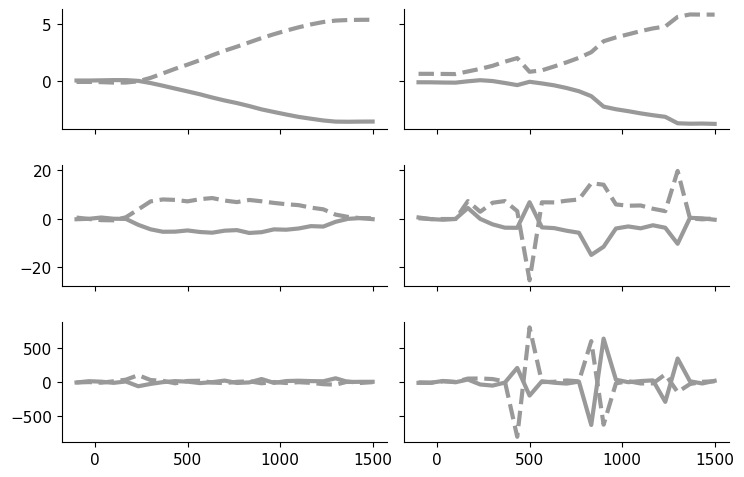

In [31]:
pure_trl = 2161
sacc_trl = 1429 #2126-5

fig, axes = plt.subplots(3,2, figsize=(7.5, 5), sharex=True, sharey="row")
plt.rcParams.update({'font.size': 12})
fig.tight_layout()

r = 0
c = 0
y_true, y_pred = get_eyeTraces(df,c_test,ya_test,yp_test,o='position',mdl=7,fold=5,trls=pure_trl)
x = np.linspace(0-(100),(1*1600)-100,y_true.shape[0])

axes[r,c].plot(x,y_true[:,0],linewidth=3,linestyle='dashed',color=(0.6,0.6,0.6))
axes[r,c].plot(x,y_true[:,1],linewidth=3,linestyle='solid',color=(0.6,0.6,0.6))

axes[r,c].spines['right'].set_color('none')
axes[r,c].spines['top'].set_color('none')

r = 1
c = 0
y_true, y_pred = get_eyeTraces(df,c_test,ya_test,yp_test,o='velocity',mdl=7,fold=5,trls=pure_trl)

axes[r,c].plot(x,-1*y_true[:,0],linewidth=3,linestyle='dashed',color=(0.6,0.6,0.6))
axes[r,c].plot(x,-1*y_true[:,1],linewidth=3,linestyle='solid',color=(0.6,0.6,0.6))

axes[r,c].spines['right'].set_color('none')
axes[r,c].spines['top'].set_color('none')

r = 2
c = 0
y_true, y_pred = get_eyeTraces(df,c_test,ya_test,yp_test,o='acceleration',mdl=7,fold=5,trls=pure_trl)

axes[r,c].plot(x,-1*y_true[:,0],linewidth=3,linestyle='dashed',color=(0.6,0.6,0.6))
axes[r,c].plot(x,-1*y_true[:,1],linewidth=3,linestyle='solid',color=(0.6,0.6,0.6))

axes[r,c].spines['right'].set_color('none')
axes[r,c].spines['top'].set_color('none')


r = 0
c = 1
y_true, y_pred = get_eyeTraces(df,c_test,ya_test,yp_test,o='position',mdl=7,fold=2,trls=sacc_trl)

axes[r,c].plot(x,y_true[:,0],linewidth=3,linestyle='dashed',color=(0.6,0.6,0.6))
axes[r,c].plot(x,y_true[:,1],linewidth=3,linestyle='solid',color=(0.6,0.6,0.6))

axes[r,c].spines['right'].set_color('none')
axes[r,c].spines['top'].set_color('none')

r = 1
c = 1
y_true, y_pred = get_eyeTraces(df,c_test,ya_test,yp_test,o='velocity',mdl=7,fold=2,trls=sacc_trl)

axes[r,c].plot(x,-1*y_true[:,0],linewidth=3,linestyle='dashed',color=(0.6,0.6,0.6))
axes[r,c].plot(x,-1*y_true[:,1],linewidth=3,linestyle='solid',color=(0.6,0.6,0.6))

axes[r,c].spines['right'].set_color('none')
axes[r,c].spines['top'].set_color('none')

r = 2
c = 1
y_true, y_pred = get_eyeTraces(df,c_test,ya_test,yp_test,o='acceleration',mdl=7,fold=2,trls=sacc_trl)

axes[r,c].plot(x,-1*y_true[:,0],linewidth=3,linestyle='dashed',color=(0.6,0.6,0.6))
axes[r,c].plot(x,-1*y_true[:,1],linewidth=3,linestyle='solid',color=(0.6,0.6,0.6))

axes[r,c].spines['right'].set_color('none')
axes[r,c].spines['top'].set_color('none')
        
plt.subplots_adjust(wspace=0.05, hspace=0.3)
fig.savefig(FIG_FOLDER+'/actual_eyeTrace_trialTypes.png', dpi=600, bbox_inches='tight')

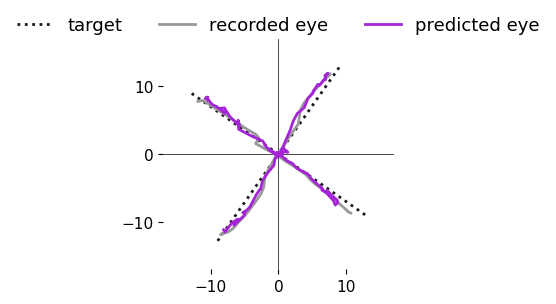

In [36]:
from matplotlib.collections import LineCollection

fig, ax = plt.subplots(figsize=(7.5, 3))
plt.rcParams.update({'font.size': 13})
fig.tight_layout()

# Generate example data (replace this with your actual data)
handles = []
labels = []
# Plotting lines starting from (0, 0) to the calculated endpoints
for i, angle_deg in enumerate([55, 145, 235, 325]):
    angle_rad = np.radians(angle_deg)
    line_length = 16
    endpoint = (line_length * np.cos(angle_rad), line_length * np.sin(angle_rad))
    
    line, = ax.plot([0, endpoint[0]], [0, endpoint[1]], color=(0.1, 0.1, 0.1), linestyle=':', linewidth=2, zorder=1)
    if i == 0:
        handles.append(line)
        labels.append('target')
        
for i in range(4):
    y_true, y_pred = get_eyeTraces(df,c_test,ya_test,yp_test,o='position',mdl=7,fold=0,trls=plot_trls[i])
    
    # Plot the true eye traces
    true_line, = ax.plot(y_true[:, 0], y_true[:, 1], linewidth=2, linestyle='solid', color=(0.6, 0.6, 0.6), zorder=2)
    if i == 0:
        handles.append(true_line)
        labels.append('recorded eye')
    
    decoded_line, = ax.plot(y_pred[:, 0], y_pred[:, 1], linewidth=2, linestyle='solid', color=cols[4], zorder=3)
    if i == 0:
        handles.append(decoded_line)
        labels.append('predicted eye')

ax.axhline(0, color='black', linestyle='-',linewidth=0.5,zorder=0)  # Dashed line at y=0
ax.axvline(0, color='black', linestyle='-',linewidth=0.5,zorder=0)  # Dashed line at x=0

plt.gca().set_aspect('equal', adjustable='box')

# Create legend with custom handles and labels
ax.legend(handles=handles, labels=labels, loc='lower center', bbox_to_anchor=(0.5, 0.95),
          fancybox=False, shadow=False, ncol=3, fontsize="13", frameon=False)

ax.set_xlim([-17,17])
ax.set_xticks([-10,0,10])
ax.set_ylim([-17,17])
ax.set_yticks([-10,0,10])
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.gca().set_aspect('equal', adjustable='box')

fig.savefig(FIG_FOLDER+'/eyeTraces_4dirs.png', dpi=600, bbox_inches='tight')

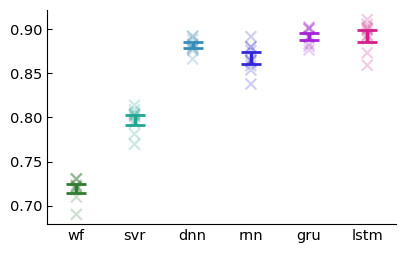

In [51]:
fig, ax = plt.subplots(1,1,figsize=(4.25,2.75)) #6,5.5
plt.rcParams.update({'font.size': 10.5})
fig.tight_layout()

val = 'R2_test_mn'
wf,wc,xgb,svr,dnn,rnn,gru,lstm = get_dfVal_folds(df,o='position',val=val)

#if val=='rmse_test_mn' or val=='rmse_train_mn':
#    for i in range(10):
#        #yr_true, yr_pred = get_eyeTraces(df,c_train,ya_train,yp_train,o='position',mdl=3,fold=i)
#        ye_true, ye_pred = get_eyeTraces(df,c_test,ya_test,yp_test,o='position',mdl=3,fold=i)
#        svr[i] = get_RMSE(ye_true, ye_pred * np.std(yr_true,axis=0)).mean()

n=10
means=([np.mean(wf),np.mean(svr),np.mean(dnn),np.mean(rnn),np.mean(gru),np.mean(lstm)])
err=([np.std(wf)*np.sqrt(1./n+1./(n-1)),np.std(svr)*np.sqrt(1./n+1./(n-1)),np.std(dnn)*np.sqrt(1./n+1./(n-1)),np.std(rnn)*np.sqrt(1./n+1./(n-1)),np.std(gru)*np.sqrt(1./n+1./(n-1)),np.std(lstm)*np.sqrt(1./n+1./(n-1))])

ind = np.arange(len(err)) #X values for plotting
for pos, y, yerr, color in zip(ind, means, err, cols): #Loop through methods and plot error bars
    ax.errorbar(pos, y, yerr, lw=2.5, capsize=7.5, capthick=2, color=color)

    ax.set_xlim([-0.5,5.5])
    ax.set_xticks(np.arange(6))
    ax.set_xticklabels(['wf','svr','dnn','rnn','gru','lstm'], rotation=0)
    #ax.set_yticks([0.7,0.8,0.9])
    #ax.set_ylim([0.6,0.95])

    #Remove right and top boundaries, and make ticks inward
    ax.tick_params(direction='in',bottom=0)
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')

    #Plot individual R2 values for each fold as an 'x'
    scatter_x=np.reshape(np.transpose(np.ones((10,1))*range(6)),(60,1)) #Get x values for plotting (first 10 will have an x value of 0, second 10 will have an x value of 1, etc)
    #scatter_x=np.reshape(np.transpose(np.ones((10,1))*range(7)),(70,1)) #Get x values for plotting (first 10 will have an x value of 0, second 10 will have an x value of 1, etc)
    
    scatter_y=np.concatenate((wf,svr,dnn,rnn,gru,lstm),axis=0) #Y values for plotting
    colors_list=[] #Create a list of the colors that should be used when plotting each 'x'
    for i in scatter_x.astype(int).reshape((1,-1))[0]:
        colors_list.append(cols[i])
        
    ax.scatter(scatter_x,scatter_y,c=colors_list,marker='x',s=60,alpha=0.04)

fig.savefig(FIG_FOLDER+'/r2_bench.png', dpi=600, bbox_inches='tight')

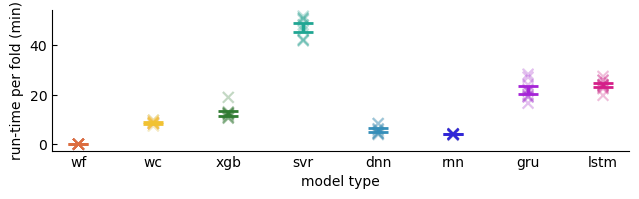

In [26]:
fig, ax = plt.subplots(1,1,figsize=(6.5,2)) #6,5.5
plt.rcParams.update({'font.size': 10})
fig.tight_layout()

val = 'train_min'
wf,wc,xgb,svr,dnn,rnn,gru,lstm = get_dfVal_folds(df,o='position',val=val)

#if val=='rmse_test_mn' or val=='rmse_train_mn':
#    for i in range(10):
#        #yr_true, yr_pred = get_eyeTraces(df,c_train,ya_train,yp_train,o='position',mdl=3,fold=i)
#        ye_true, ye_pred = get_eyeTraces(df,c_test,ya_test,yp_test,o='position',mdl=3,fold=i)
#        svr[i] = get_RMSE(ye_true, ye_pred * np.std(yr_true,axis=0)).mean()

n=10
means=([np.mean(wf),np.mean(wc),np.mean(xgb),np.mean(svr),np.mean(dnn),np.mean(rnn),np.mean(gru),np.mean(lstm)])
err=([np.std(wf)*np.sqrt(1./n+1./(n-1)),np.std(wc)*np.sqrt(1./n+1./(n-1)),np.std(xgb)*np.sqrt(1./n+1./(n-1)),np.std(svr)*np.sqrt(1./n+1./(n-1)),np.std(dnn)*np.sqrt(1./n+1./(n-1)),np.std(rnn)*np.sqrt(1./n+1./(n-1)),np.std(gru)*np.sqrt(1./n+1./(n-1)),np.std(lstm)*np.sqrt(1./n+1./(n-1))])

ind = np.arange(len(err)) #X values for plotting
for pos, y, yerr, color in zip(ind, means, err, cols): #Loop through methods and plot error bars
    ax.errorbar(pos, y, yerr, lw=2.5, capsize=7.5, capthick=2, color=color)

    ax.set_xticks(np.arange(8))
    ax.set_xticklabels(['wf','wc','xgb','svr','dnn','rnn','gru','lstm'], rotation=0)
    ax.set_ylabel('run-time per fold (min)')
    ax.set_xlabel('model type')
    #ax.set_yticks([0.7,0.8,0.9])
    #ax.set_ylim([0.6,0.95])

    #Remove right and top boundaries, and make ticks inward
    ax.tick_params(direction='in',bottom=0)
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')

    #Plot individual R2 values for each fold as an 'x'
    scatter_x=np.reshape(np.transpose(np.ones((10,1))*range(8)),(80,1)) #Get x values for plotting (first 10 will have an x value of 0, second 10 will have an x value of 1, etc)
    #scatter_x=np.reshape(np.transpose(np.ones((10,1))*range(7)),(70,1)) #Get x values for plotting (first 10 will have an x value of 0, second 10 will have an x value of 1, etc)
    
    scatter_y=np.concatenate((wf,wc,xgb,svr,dnn,rnn,gru,lstm),axis=0) #Y values for plotting
    colors_list=[] #Create a list of the colors that should be used when plotting each 'x'
    for i in scatter_x.astype(int).reshape((1,-1))[0]:
        colors_list.append(cols[i])
     
    ax.scatter(scatter_x,scatter_y,c=colors_list,marker='x',s=60,alpha=0.04)

    
#fig.savefig(FIG_FOLDER+'/r2_10folds.png', dpi=300, bbox_inches='tight')

## Figure 2. Detailed decoding schematic

(65,)
(235381,)
65
381
Index([0, 1, 2, 9, 11, 13, 15, 16, 23, 25, 27, 31, 37], dtype='int64')
[-8.398328683574878, 10.944996693840578]


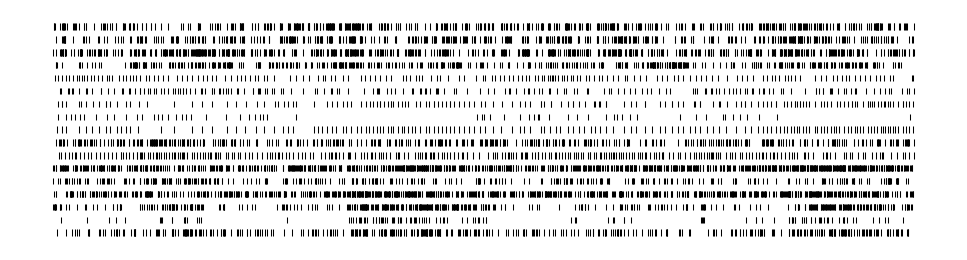

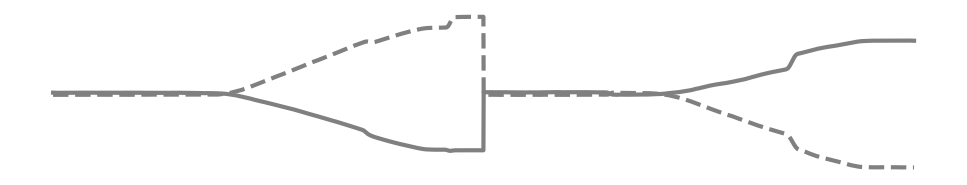

In [13]:
dt = 50
data = io.loadmat('/Users/kendranoneman/Projects/mayo/NeuralDecoding/datasets/vars/vars-pa29dir4A-pre500-post300.mat')

spike_times  =  data['spike_times'] # spike times of all neurons
pos          =  data['pos'] # x and y eye positions
vel         =  data['vels']
acc          =  data['acc']
out_times    =  data['vels_times'] # times at which velocities were recorded
out_times    =  np.squeeze(out_times)

conditions = data['contConditions']
#print(np.unique(conditions[:,0]).shape)

spike_times  =  np.squeeze(spike_times)
for i in range(spike_times.shape[0]):
    spike_times[i]  =  np.squeeze(spike_times[i])
    
print(spike_times.shape)
print(spike_times[0].shape)
    
unts = pd.read_csv('/Users/kendranoneman/Projects/mayo/NeuralDecoding/datasets/units/units-pa29dir4A-pre500-post300.csv')
fef = unts[(unts['signiffl'] == 1) & (unts['BrainArea'] == 'FEF') & (unts['DI'] > 0.175)].index
mt = unts[(unts['signiffl'] == 1) & (unts['BrainArea'] == 'MT') & (unts['DI'] > 0.175)].index

#print(fef.shape[0] + mt.shape[0])
    
##############################################################################################
#trial = [1861] #1858. 1861. 1879. 1882. 1883.

trls = [plot_trls[3]]
trls = [1858,1861]

spikes = []
for sublist in spike_times:
    s = sublist[np.logical_and(sublist>np.where(np.isin(conditions[:,0],trls))[0][0], sublist<np.where(np.isin(conditions[:,0],trls))[0][-1])]
    spikes.append(s)
    
print(len(spikes))
print(len(spikes[0]))
    
fig, ax = plt.subplots(figsize=(10.2, 3))
fig.tight_layout()

print(fef)

ax.eventplot([spikes[i] for i in fef], colors='black', linelengths=0.5, linewidths=0.75, lineoffsets=np.arange(len([spikes[i] for i in fef])));
ax.eventplot([spikes[i] for i in mt], colors='black', linelengths=0.5, linewidths=0.75, lineoffsets=np.arange(len([spikes[i] for i in fef]),len([spikes[i] for i in fef])+len([spikes[i] for i in mt])));

ax.eventplot([spikes[i] for i in fef], colors='black', linelengths=0.5, linewidths=0.75, lineoffsets=np.arange(len([spikes[i] for i in fef])));

ax.axis('off')
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

fig.savefig(FIG_FOLDER+'/examp_spikes.png', dpi=300, bbox_inches='tight')

##############################################################
fig2a, ax = plt.subplots(figsize=(10.2, 2.25))
fig2a.tight_layout()

poses = pos[np.isin(conditions[:,0],trls)]
ttt = 4
print([poses[320*ttt:320*(ttt+1),1].mean(),poses[320*ttt:320*(ttt+1),0].mean()])

ax.plot((poses[:,0]), label='HE', color='gray', linestyle='--', linewidth=3)
ax.plot(poses[:,1], label='VE', color='gray', linestyle='-', linewidth=3)

#ax.axvline(x=3000, color='red', linestyle='--')
#ax.axvline(x=3200, color='red', linestyle='--')

#ax.set_xlim(400,900)

ax.axis('off')
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

fig2a.savefig(FIG_FOLDER+'/examp_eyepos.png', dpi=300, bbox_inches='tight');

In [ ]:
saveFigs = 1

dt = 50
data = io.loadmat('/Users/kendranoneman/Projects/mayo/NeuralDecoding/datasets/vars/vars-pa29dir4A-pre500-post300.mat')

spike_times  =  data['spike_times'] # spike times of all neurons
pos          =  data['pos'] # x and y eye positions
vel         =  data['vels']
acc          =  data['acc']
out_times    =  data['vels_times'] # times at which velocities were recorded
out_times    =  np.squeeze(out_times)

conditions = data['contConditions']

spike_times  =  np.squeeze(spike_times)
for i in range(spike_times.shape[0]):
    spike_times[i]  =  np.squeeze(spike_times[i])
    
unts = pd.read_csv('/Users/kendranoneman/Projects/mayo/NeuralDecoding/datasets/units/units-pa29dir4A-pre500-post300.csv')
fef = unts[(unts['BrainArea'] == 'FEF') & (unts['SNR'] > 4) & (unts['mnFR_bestDir'] < 30)].index
mt = unts[(unts['BrainArea'] == 'MT') & (unts['SNR'] > 1) & (unts['mnFR_bestDir'] < 30)].index

print(fef.shape[0])
print(mt.shape[0])
    
##############################################################################################
#trial = [1861] #1858. 1861. 1879. 1882. 1883.

trls = plot_trls[0:2]
#trls = [1858,1861]

spikes = []
for sublist in spike_times:
    s = sublist[np.logical_and(sublist>np.where(np.isin(conditions[:,0],trls))[0][0], sublist<np.where(np.isin(conditions[:,0],trls))[0][-1])]
    spikes.append(s)
    
fig, ax = plt.subplots(figsize=(15, 1.5))
fig.tight_layout()

ax.eventplot([spikes[i] for i in fef], colors='black', linelengths=0.5, linewidths=0.11, lineoffsets=np.arange(len([spikes[i] for i in fef])));
ax.eventplot([spikes[i] for i in mt], colors='black', linelengths=0.5, linewidths=0.11, lineoffsets=np.arange(len([spikes[i] for i in fef]),len([spikes[i] for i in fef])+len([spikes[i] for i in mt])));

ax.axis('off')
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

fig.savefig(FIG_FOLDER+'/examp_spikes_crossVal.png', dpi=300, bbox_inches='tight')

##############################################################
fig2a, ax = plt.subplots(figsize=(15, 1.5))
fig2a.tight_layout()

trls = [plot_trls[0], plot_trls[1], plot_trls[2], plot_trls[3], 1861, 1858, 1879, 1882, 1883, 1861, 1862]

poses = pos[np.isin(conditions[:,0],trls)]
ttt = 4
print([poses[320*ttt:320*(ttt+1),1].mean(),poses[320*ttt:320*(ttt+1),0].mean()])

ax.plot((poses[:,0]), label='HE', color='gray', linestyle='--', linewidth=3)
ax.plot(poses[:,1], label='VE', color='gray', linestyle='-', linewidth=3)

#ax.set_xlim(400,900)

ax.axis('off')
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

fig2a.savefig(FIG_FOLDER+'/examp_eyepos_crossVal.png', dpi=300, bbox_inches='tight');

## Figure 3. Eye kinematic reconstructions

In [ ]:
column_names = ['line','sess','timePrePost','output_binWidth','downsample_factor','input_timeWindow','input_binWidth','numNeurons','nMT','nFEF','outer_fold','repeat','trainRatio','numObservations','output','model','prms','preProcess_time','train_time','test_time','R2_train','rho_train','rmse_train','R2_test','rho_test','rmse_test']
df, yp_test = get_outputs(DATA_FOLDER,["s29","r0001"],column_names,lrange=[0,239],withTraces=True) # position
ya_test, c_test = get_actualTraces(DATA_FOLDER, df)

# Get trial numbers for "best" trial in each direction, will be used for all eye traces plots
#plot_trls = get_exTrialLabels(df,c_test,ya_test,yp_test,o='acceleration',fold=0,mdl=7,gi=1)
plot_trls = get_exTrialLabels(df,c_test,ya_test,yp_test,fold=0,o='acceleration',gi=1)

print(plot_trls)

df.head(3)

In [ ]:
fig, axes = plt.subplots(len(df['model'].unique()),3,figsize=(11,11), sharex=True, sharey=False)
plt.rcParams.update({'font.size': 10.2})
fig.tight_layout()

lws = [2,2,1.7]

for r, mod in enumerate(df['model'].unique()):
    for c, kin in enumerate(df['output'].unique()):
        y_true, y_pred = get_eyeTraces(df,c_test,ya_test,yp_test,o=kin,mdl=mod,fold=0,trls=plot_trls)
        x = np.linspace(0,4*1.6,y_true.shape[0])

        axes[r,c].plot(x,y_true[:,0],linewidth=lws[c],linestyle='solid',color=(0.6,0.6,0.6))
        axes[r,c].plot(x,y_true[:,1],linewidth=lws[c],linestyle='dashed',color=(0.6,0.6,0.6))

        #if mod==3:
        #    axes[r,c].plot(x,y_pred[:,0]*np.std(y_true[:,0]),linewidth=lws[c],linestyle='solid',color=cols[r])
        #    axes[r,c].plot(x,y_pred[:,1]*np.std(y_true[:,1]),linewidth=lws[c],linestyle='dashed',color=cols[r])

        #    r2 = get_R2(y_true,y_pred * np.std(y_true,axis=0))

        #else:
        axes[r,c].plot(x,y_pred[:,0],linewidth=lws[c],linestyle='solid',color=cols[r])
        axes[r,c].plot(x,y_pred[:,1],linewidth=lws[c],linestyle='dashed',color=cols[r])

        r2 = get_R2(y_true,y_pred)

        text_box = f"$R^2_x$ = {r2[0]:.2f}, $R^2_y$ = {r2[1]:.2f}"
        axes[r,c].text(0.5, 0.96, text_box, transform=axes[r,c].transAxes, fontsize=9.69, ha='center', va='bottom', color=cols[r])

        axes[r,c].spines['right'].set_color('none')
        #axes[i].spines['bottom'].set_color('none')
        axes[r,c].spines['top'].set_color('none')
        
        if mod!=7:
            axes[r,c].set_yticklabels([])
        
        if c==0:
            axes[r,c].set_ylim([-15,15])
        elif c==1:
            axes[r,c].set_ylim([-40,40])
            axes[r,c].set_yticks([-30,0,30])
        else:
            axes[r,c].set_ylim([-200,200])
            axes[r,c].set_yticks([-150,0,150])
            
plt.subplots_adjust(wspace=0.153, hspace=0.25)
fig.savefig(FIG_FOLDER+'/allTraces_8models_r2xy.png', dpi=300, bbox_inches='tight')

## Figure 4. Summary decoder results

In [29]:
column_names = ['line','sess','timePrePost','output_binWidth','downsample_factor','input_timeWindow','input_binWidth','numNeurons','nMT','nFEF','outer_fold','repeat','trainRatio','numObservations','output','model','prms','preProcess_time','train_time','test_time','R2_train','rho_train','rmse_train','R2_test','rho_test','rmse_test']
df, _ = get_outputs(DATA_FOLDER,["r0001"],column_names,lrange=[0,239],withTraces=False) # position
#ya_test, c_test = get_actualTraces(DATA_FOLDER, df)
#df = fix_svr(df,yp_train,yp_test,ya_train,ya_test)

df_summary = df.groupby(['sess', 'output', 'model']).agg(
    R2_train_mn=('R2_train_mn', 'mean'),
    R2_test_mn=('R2_test_mn', 'mean')
).reset_index()

print(df['preProcess_time'].mean())
df.head(3)

0.09605061630829685


,line,sess,timePrePost,output_binWidth,downsample_factor,input_timeWindow,input_binWidth,numNeurons,nMT,nFEF,...,rmse_train,R2_test,rho_test,rmse_test,R2_test_mn,rho_test_mn,rmse_test_mn,R2_train_mn,rho_train_mn,rmse_train_mn
0,0,17,0,50,1,400,50,49,24,25,...,"[3.482117176361492, 4.553448575584876]","[0.4935290340379034, 0.2447182961317912]","[[0.7037876596044313, 0.497044055682385]]","[3.644878443143173, 4.694333882228394]",0.369124,0.600416,4.169606,0.400179,0.624289,4.017783
1,0,17,0,50,1,400,50,49,24,25,...,"[3.464539275132706, 4.544211279566037]","[0.48666383284387715, 0.23486758946851383]","[[0.7016505319487047, 0.5007152497798172]]","[3.6581724394623696, 4.7413795594635175]",0.360766,0.601183,4.199776,0.403130,0.626363,4.004375
2,0,17,0,50,1,400,50,49,24,25,...,"[3.4613563423982017, 4.543300090362491]","[0.48857074932314715, 0.23048291511659935]","[[0.7129800890683189, 0.49606088212172966]]","[3.6182263096736893, 4.649873091905787]",0.359527,0.604520,4.134050,0.402383,0.625777,4.002328


[0.719649408045971, 0.7198950591080142, 0.725650319671485, 0.7974549535304586, 0.8815183945163005, 0.8668274055998569, 0.8917512559263875, 0.8924335060625918]
[0.5015448714812658, 0.5018807320849918, 0.47641519547824557, 0.5207843360097364, 0.6004282077797503, 0.6155902809448542, 0.6372811402840743, 0.6351827447319721]
[0.006018061443556738, 0.004621727124184555, -0.0023997878888462445, 0.0007279628517084912, 0.012389359947746814, 0.010832511544192302, 0.01790454082354593, 0.01486140760585879]
9


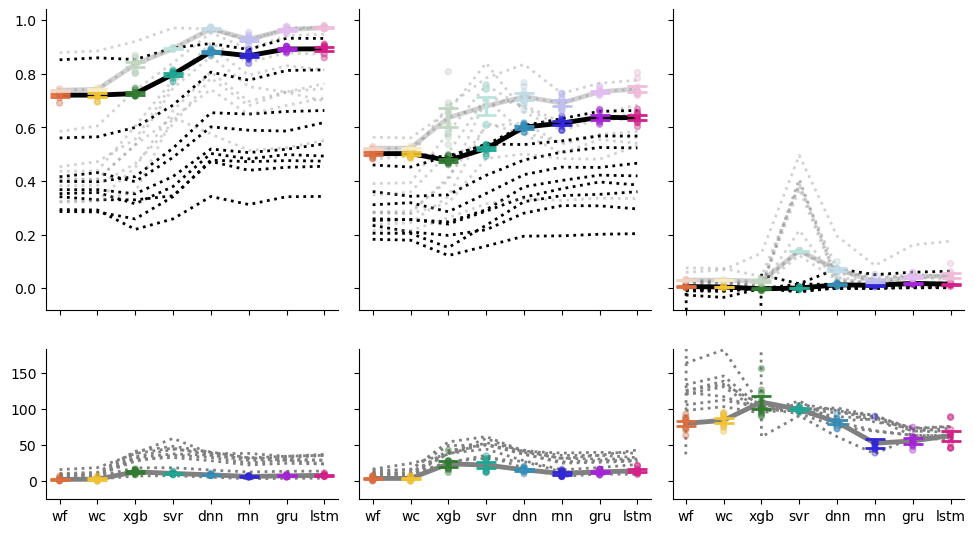

In [6]:
fig, axes = plt.subplots(2,3,figsize=(10,5.5), sharex=True, sharey='row',gridspec_kw={'height_ratios': [2, 1]}) #6,5.5
plt.rcParams.update({'font.size': 10.25})
fig.tight_layout()

#sessions = get_goodSessions(df,0.1,em='R2',val='R2_test_mn')
models = ['wf', 'wc', 'xgb', 'svr', 'dnn', 'rnn', 'gru', 'lstm']
#print(sessions)

for c, kin in enumerate(df['output'].unique()):
    for s,sess in enumerate(df['sess'].unique()): 
        wf_tr,wc_tr,xgb_tr,svr_tr,dnn_tr,rnn_tr,gru_tr,lstm_tr = get_dfVal_folds(df.loc[(df['sess']==sess)],o=kin,val='R2_train_mn')
        wf_te,wc_te,xgb_te,svr_te,dnn_te,rnn_te,gru_te,lstm_te = get_dfVal_folds(df.loc[(df['sess']==sess)],o=kin,val='R2_test_mn')

        for model in models:
            train_set = globals()[f'{model}_tr']
            test_set = globals()[f'{model}_te']
            globals()[f'{model}_gp'] = gen_gap(train_set, test_set)
                
        for q in range(3):
            if q==0:
                wf,wc,xgb,svr,dnn,rnn,gru,lstm = wf_te,wc_te,xgb_te,svr_te,dnn_te,rnn_te,gru_te,lstm_te
                r = 0
            elif q==1:
                wf,wc,xgb,svr,dnn,rnn,gru,lstm =  wf_tr,wc_tr,xgb_tr,svr_tr,dnn_tr,rnn_tr,gru_tr,lstm_tr
                r = 0
            else:
                wf,wc,xgb,svr,dnn,rnn,gru,lstm =  wf_gp,wc_gp,xgb_gp,svr_gp,dnn_gp,rnn_gp,gru_gp,lstm_gp
                r = 1
                
            n=10
            means=([np.mean(wf),np.mean(wc),np.mean(xgb),np.mean(svr),np.mean(dnn),np.mean(rnn),np.mean(gru),np.mean(lstm)])    
            err=([np.std(wf)*np.sqrt(1./n+1./(n-1)),np.std(wc)*np.sqrt(1./n+1./(n-1)),np.std(xgb)*np.sqrt(1./n+1./(n-1)),np.std(svr)*np.sqrt(1./n+1./(n-1)),np.std(dnn)*np.sqrt(1./n+1./(n-1)),np.std(rnn)*np.sqrt(1./n+1./(n-1)),np.std(gru)*np.sqrt(1./n+1./(n-1)),np.std(lstm)*np.sqrt(1./n+1./(n-1))])

            ind = np.arange(len(err)) #X values for plotting
            if q==0:
                axes[r,c].plot(ind,means,color='black',alpha=1,linestyle='dotted',linewidth=2,label=s,zorder=0)
            elif q==1:
                axes[r,c].plot(ind,means,color='gray',alpha=0.35,linestyle='dotted',linewidth=2,label=s,zorder=0)
            else:
                axes[r,c].plot(ind,means,color='gray',alpha=1,linestyle='dotted',linewidth=2,label=s,zorder=0)
            
                
            if sess==29:
                n=10
                means=([np.mean(wf),np.mean(wc),np.mean(xgb),np.mean(svr),np.mean(dnn),np.mean(rnn),np.mean(gru),np.mean(lstm)])
                err=([np.std(wf)*np.sqrt(1./n+1./(n-1)),np.std(wc)*np.sqrt(1./n+1./(n-1)),np.std(xgb)*np.sqrt(1./n+1./(n-1)),np.std(svr)*np.sqrt(1./n+1./(n-1)),np.std(dnn)*np.sqrt(1./n+1./(n-1)),np.std(rnn)*np.sqrt(1./n+1./(n-1)),np.std(gru)*np.sqrt(1./n+1./(n-1)),np.std(lstm)*np.sqrt(1./n+1./(n-1))])
                
                ind = np.arange(len(err)) #X values for plotting

                if q==0:
                    axes[r,c].plot(ind,means,color='black',alpha=1,linestyle='solid',linewidth=3.5,label=s,zorder=2)
                    print(means)
                    thiscol = cols
                    zz = 3
                elif q==1:
                    axes[r,c].plot(ind,means,color='gray',alpha=0.35,linestyle='solid',linewidth=3.5,label=s,zorder=1)
                    thiscol = grays
                    zz = 2
                else:
                    axes[r,c].plot(ind,means,color='gray',alpha=1,linestyle='solid',linewidth=3.5,label=s,zorder=1)
                    thiscol = cols
                    zz = 3
                    
                    
                for pos, y, yerr, color in zip(ind, means, err, thiscol): #Loop through methods and plot error bars

                    axes[r,c].errorbar(pos, y, yerr, lw=2.5, capsize=7.5, capthick=2, color=color,zorder=zz)

                    axes[r,c].set_xticks([0,1,2,3,4,5,6,7])
                    axes[r,c].set_xticklabels(['wf','wc','xgb','svr','dnn','rnn','gru','lstm'], rotation=0)

                    #Remove right and top boundaries, and make ticks inward
                    #axes[r,c].tick_params(direction='out',bottom=0)
                    axes[r,c].spines['right'].set_color('none')
                    axes[r,c].spines['top'].set_color('none')

                    #Plot individual R2 values for each fold as an 'x'
                    scatter_x=np.reshape(np.transpose(np.ones((10,1))*range(8)),(80,1)) #Get x values for plotting (first 10 will have an x value of 0, second 10 will have an x value of 1, etc)
                    scatter_y=np.concatenate((wf,wc,xgb,svr,dnn,rnn,gru,lstm),axis=0) #Y values for plotting
                    colors_list=[] #Create a list of the colors that should be used when plotting each 'x'
                    for i in scatter_x.astype(int).reshape((1,-1))[0]:
                        colors_list.append(thiscol[i])

                    axes[r,c].scatter(scatter_x,scatter_y,c=colors_list,marker='.',s=70,alpha=0.05,zorder=2,edgecolors='face')

            if r==0:
                axes[r,c].set_ylim([-0.08,1.04])
                axes[r,c].set_yticks([0,0.2,0.4,0.6,0.8,1.0])
            else:
                axes[r,c].set_ylim([-25,183])
                axes[r,c].set_yticks([0,50,100,150])
                
print(s)
plt.subplots_adjust(wspace=0.075, hspace=0.175)
fig.savefig(FIG_FOLDER+'/r2_allSessions.png', dpi=300, bbox_inches='tight')



[0.719649408045971, 0.7198950591080142, 0.725650319671485, 0.7974549535304586, 0.8815183945163005, 0.8668274055998569, 0.8917512559263875, 0.8924335060625918]
[0.5015448714812658, 0.5018807320849918, 0.47641519547824557, 0.5207843360097364, 0.6004282077797503, 0.6155902809448542, 0.6372811402840743, 0.6351827447319721]
[0.006018061443556738, 0.004621727124184555, -0.0023997878888462445, 0.0007279628517084912, 0.012389359947746814, 0.010832511544192302, 0.01790454082354593, 0.01486140760585879]
4


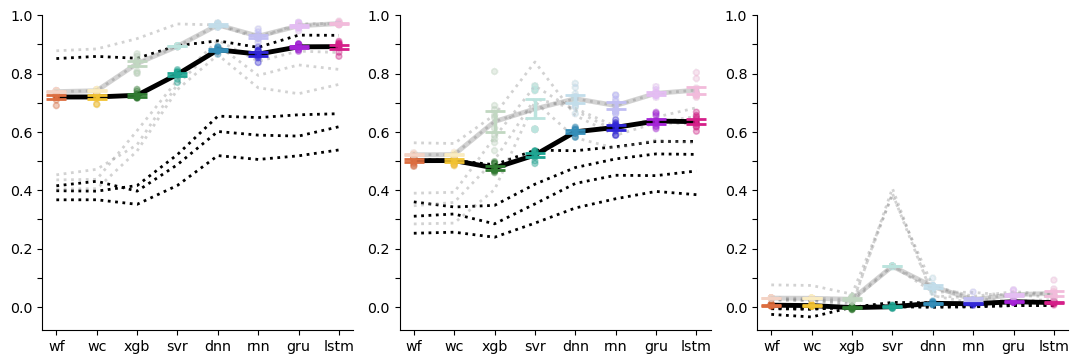

In [33]:
fig, axes = plt.subplots(1,3,figsize=(11,3.75), sharex=True, sharey=False) #6,5.5
plt.rcParams.update({'font.size': 10.25})
fig.tight_layout()

sessions = [26,29,22,32,17] #get_goodSessions(df,0.1,em='R2',val='R2_test_mn')
models = ['wf', 'wc', 'xgb', 'svr', 'dnn', 'rnn', 'gru', 'lstm']
#print(sessions)

for c, kin in enumerate(df['output'].unique()):
    for s,sess in enumerate(sessions): 
        wf_tr,wc_tr,xgb_tr,svr_tr,dnn_tr,rnn_tr,gru_tr,lstm_tr = get_dfVal_folds(df.loc[(df['sess']==sess)],o=kin,val='R2_train_mn')
        wf_te,wc_te,xgb_te,svr_te,dnn_te,rnn_te,gru_te,lstm_te = get_dfVal_folds(df.loc[(df['sess']==sess)],o=kin,val='R2_test_mn')

        for model in models:
            train_set = globals()[f'{model}_tr']
            test_set = globals()[f'{model}_te']
            globals()[f'{model}_gp'] = gen_gap(train_set, test_set)
                
        for q in range(2):
            if q==0:
                wf,wc,xgb,svr,dnn,rnn,gru,lstm = wf_te,wc_te,xgb_te,svr_te,dnn_te,rnn_te,gru_te,lstm_te
                r = 0
            elif q==1:
                wf,wc,xgb,svr,dnn,rnn,gru,lstm =  wf_tr,wc_tr,xgb_tr,svr_tr,dnn_tr,rnn_tr,gru_tr,lstm_tr
                r = 0
            else:
                wf,wc,xgb,svr,dnn,rnn,gru,lstm =  wf_gp,wc_gp,xgb_gp,svr_gp,dnn_gp,rnn_gp,gru_gp,lstm_gp
                r = 1
                
            n=10
            means=([np.mean(wf),np.mean(wc),np.mean(xgb),np.mean(svr),np.mean(dnn),np.mean(rnn),np.mean(gru),np.mean(lstm)])    
            err=([np.std(wf)*np.sqrt(1./n+1./(n-1)),np.std(wc)*np.sqrt(1./n+1./(n-1)),np.std(xgb)*np.sqrt(1./n+1./(n-1)),np.std(svr)*np.sqrt(1./n+1./(n-1)),np.std(dnn)*np.sqrt(1./n+1./(n-1)),np.std(rnn)*np.sqrt(1./n+1./(n-1)),np.std(gru)*np.sqrt(1./n+1./(n-1)),np.std(lstm)*np.sqrt(1./n+1./(n-1))])

            ind = np.arange(len(err)) #X values for plotting
            if q==0:
                axes[c].plot(ind,means,color='black',alpha=1,linestyle='dotted',linewidth=2,label=s,zorder=0)
            elif q==1:
                axes[c].plot(ind,means,color='gray',alpha=0.35,linestyle='dotted',linewidth=2,label=s,zorder=0)
            else:
                axes[c].plot(ind,means,color='gray',alpha=1,linestyle='dotted',linewidth=2,label=s,zorder=0)
            
                
            if sess==29:
                n=10
                means=([np.mean(wf),np.mean(wc),np.mean(xgb),np.mean(svr),np.mean(dnn),np.mean(rnn),np.mean(gru),np.mean(lstm)])
                err=([np.std(wf)*np.sqrt(1./n+1./(n-1)),np.std(wc)*np.sqrt(1./n+1./(n-1)),np.std(xgb)*np.sqrt(1./n+1./(n-1)),np.std(svr)*np.sqrt(1./n+1./(n-1)),np.std(dnn)*np.sqrt(1./n+1./(n-1)),np.std(rnn)*np.sqrt(1./n+1./(n-1)),np.std(gru)*np.sqrt(1./n+1./(n-1)),np.std(lstm)*np.sqrt(1./n+1./(n-1))])
                
                ind = np.arange(len(err)) #X values for plotting

                if q==0:
                    axes[c].plot(ind,means,color='black',alpha=1,linestyle='solid',linewidth=3.5,label=s,zorder=2)
                    print(means)
                    thiscol = cols
                    zz = 3
                elif q==1:
                    axes[c].plot(ind,means,color='gray',alpha=0.35,linestyle='solid',linewidth=3.5,label=s,zorder=1)
                    thiscol = grays
                    zz = 2
                else:
                    axes[c].plot(ind,means,color='gray',alpha=1,linestyle='solid',linewidth=3.5,label=s,zorder=1)
                    thiscol = cols
                    zz = 3
                    
                    
                for pos, y, yerr, color in zip(ind, means, err, thiscol): #Loop through methods and plot error bars

                    axes[c].errorbar(pos, y, yerr, lw=2.5, capsize=7.5, capthick=2, color=color,zorder=zz)

                    axes[c].set_xticks([0,1,2,3,4,5,6,7])
                    axes[c].set_xticklabels(['wf','wc','xgb','svr','dnn','rnn','gru','lstm'], rotation=0)

                    #Remove right and top boundaries, and make ticks inward
                    #axes[r,c].tick_params(direction='out',bottom=0)
                    axes[c].spines['right'].set_color('none')
                    axes[c].spines['top'].set_color('none')

                    #Plot individual R2 values for each fold as an 'x'
                    scatter_x=np.reshape(np.transpose(np.ones((10,1))*range(8)),(80,1)) #Get x values for plotting (first 10 will have an x value of 0, second 10 will have an x value of 1, etc)
                    scatter_y=np.concatenate((wf,wc,xgb,svr,dnn,rnn,gru,lstm),axis=0) #Y values for plotting
                    colors_list=[] #Create a list of the colors that should be used when plotting each 'x'
                    for i in scatter_x.astype(int).reshape((1,-1))[0]:
                        colors_list.append(thiscol[i])

                    axes[c].scatter(scatter_x,scatter_y,c=colors_list,marker='.',s=70,alpha=0.05,zorder=2,edgecolors='face')

            if r==0:
                axes[c].set_ylim([-0.08,1])
                axes[c].set_yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
                axes[c].set_yticklabels(['0.0','','0.2','','0.4','','0.6','','0.8','','1.0'])
            else:
                axes[c].set_ylim([-25,183])
                axes[c].set_yticks([0,50,100,150])
                
print(s)
plt.subplots_adjust(wspace=0.15, hspace=0.175)
fig.savefig(FIG_FOLDER+'/r2_allSessions.png', dpi=300, bbox_inches='tight')

In [34]:
# Set display options to show all rows
pd.set_option('display.max_rows', None)

df_pivot = df_summary.pivot_table(
    index=['sess', 'model'],  # Keep 'sess' and 'model' as index
    columns='output',         # Use 'output' as columns (position, velocity, acceleration)
    values=['R2_test_mn']  # Values to pivot
)

df_pivot = df_pivot.reindex(columns=['position', 'velocity', 'acceleration'], level=1)
df_pivot = df_pivot.round(2)

# Step 1: Group by 'sess' and calculate the mean R2_test_mn across all 'model' and 'output' values
df_mean_r2 = df_pivot.groupby('sess').mean()

# Step 2: Rank the sessions by the average R2_test_mn across all outputs (position, velocity, acceleration)
df_ranked = df_mean_r2.mean(axis=1).sort_values(ascending=False)

# Step 3: Map the rank of each 'sess' back to df_pivot
df_pivot['sess_rank'] = df_pivot.index.get_level_values('sess').map(df_ranked.index.get_loc)

# Step 4: Sort by 'sess_rank' first, then by 'model' (model in its natural order)
df_pivot_sorted = df_pivot.sort_values(['sess_rank', 'model'], ascending=[True, True])

# Drop the 'sess_rank' column as it's no longer needed
df_pivot_sorted = df_pivot_sorted.drop(columns='sess_rank')

# Display the sorted df_pivot DataFrame
print(df_pivot_sorted)


           R2_test_mn                      
output       position velocity acceleration
sess model                                 
26   0           0.85     0.51        -0.03
     1           0.86     0.50        -0.03
     2           0.85     0.49        -0.00
     3           0.90     0.54         0.02
     4           0.91     0.54         0.01
     5           0.89     0.55         0.01
     6           0.93     0.57         0.02
     7           0.93     0.57         0.02
29   0           0.72     0.50         0.01
     1           0.72     0.50         0.00
     2           0.73     0.48        -0.00
     3           0.80     0.52         0.00
     4           0.88     0.60         0.01
     5           0.87     0.62         0.01
     6           0.89     0.64         0.02
     7           0.89     0.64         0.01
22   0           0.40     0.36        -0.00
     1           0.40     0.34        -0.00
     2           0.42     0.35        -0.00
     3           0.52     0.42  

# Figure 5. AMOUNT of data impact on accuracy/generalization

In [12]:
column_names = ['line','sess','timePrePost','output_binWidth','downsample_factor','input_timeWindow','input_binWidth','numNeurons','nMT','nFEF','outer_fold','repeat','trainRatio','numObservations','output','model','prms','preProcess_time','train_time','test_time','R2_train','rho_train','rmse_train','R2_test','rho_test','rmse_test']
df, _ = get_outputs(DATA_FOLDER,["s29"],column_names,lrange=[240,959], withTraces=False) # position

maxTime = (np.unique(df['numObservations']).max()) * (5/100) * (1/60)
print(maxTime)

df.head(300)

KeyboardInterrupt: 

In [33]:
(34*0.7)

23.799999999999997

(3, 8, 14)
(14,)
(3, 8, 16)
(16,)


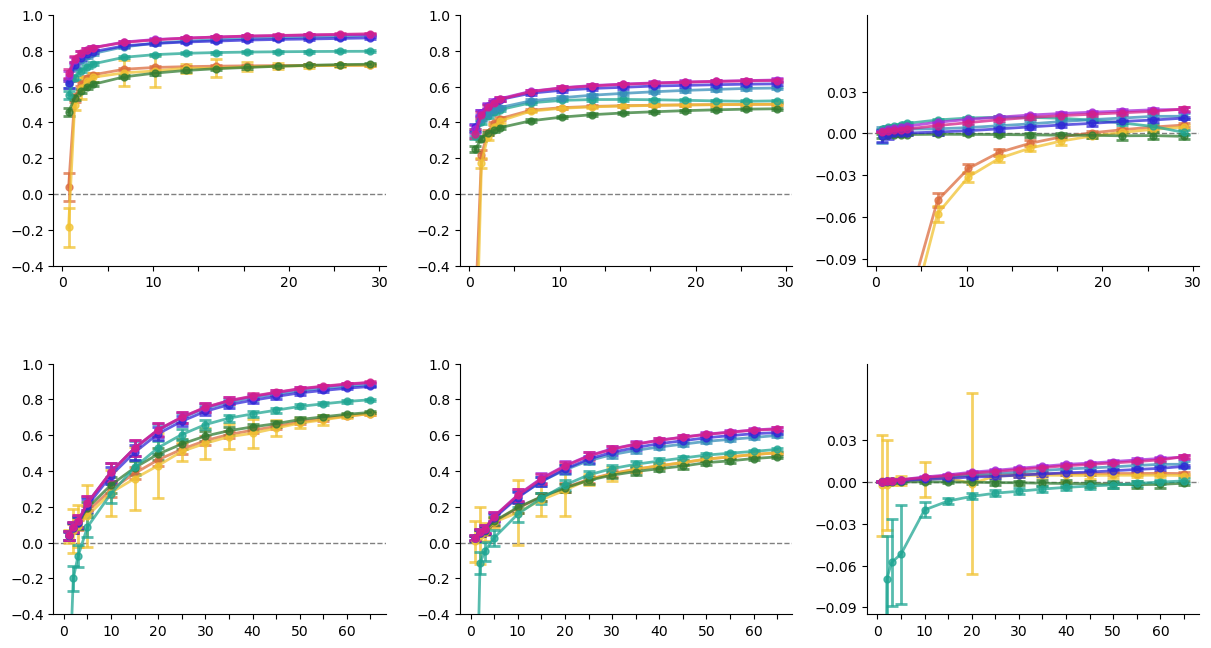

In [6]:
import matplotlib.ticker as ticker
from scipy.stats import mannwhitneyu

fig, ax = plt.subplots(2, 3, figsize=(12.2, 6.6), sharex=False, sharey='col') #, gridspec_kw={'width_ratios': [3, 2]}
plt.rcParams.update({'font.size': 10.5})
fig.tight_layout()

################################### training set size ############################
kins = ['position','velocity','acceleration']
beh = 'R2_test_mn'
num_bins = 14

ts_stats = np.zeros((3,len(df['model'].unique()),len(df['trainRatio'].unique())))
for k, kin in enumerate(kins):
    dff = df.loc[(df['output']==kin) & (df['nMT']==24) & (df['nFEF']==41)]
    dff = dff.copy()
    dff = dff[dff[beh] >= -10]

    #dff.loc[:, 'trainSet_dur'] = (dff['numObservations'] * dff['output_binWidth']) / (1000*60)
    #dff.loc[:, 'trainSet_size'] = (dff['numObservations']/dff['numObservations'].max())*100

    dff = dff[['model', 'trainRatio', beh, 'outer_fold','repeat']]
    dff = dff.groupby(['model', 'trainRatio', 'outer_fold','repeat'])[beh].mean().reset_index()
    obw = np.sort(df['trainRatio'].unique())

    #df_mn = dff.groupby(['model', pd.cut(dff['trainSet_size'], bins=num_bins)])[beh].mean().reset_index(name="mR2")
    #df_sd = dff.groupby(['model', pd.cut(dff['trainSet_size'], bins=num_bins)])[beh].std().reset_index(name="sR2")

    df_mn = dff.groupby(['model', 'trainRatio'])[beh].mean().reset_index(name="mR2")
    df_sd = dff.groupby(['model', 'trainRatio'])[beh].std().reset_index(name="sR2")

    for i,m in enumerate(df['model'].unique()):
        baseline = df.loc[(df['trainRatio']==1) & (df['model']==m) & (df['output']==kin) & (df['nMT']==24) & (df['nFEF']==41)][beh].values
        baseline = np.repeat(a = baseline, repeats = 100)

        for j,sz in enumerate(sorted(df['trainRatio'].unique())):
            this_model = df.loc[(df['model']==m) & (df['trainRatio']==sz) & (df['output']==kin) & (df['nMT']==24) & (df['nFEF']==41)][beh].values
            _, pval = signif_test(baseline,this_model)
            ts_stats[k,i,j] = pval

        mod_mn = df_mn[(df_mn['model'] == m)]['mR2'].values
        mod_sd = (df_sd[(df_sd['model'] == m)]['sR2'].values) * np.sqrt(1. / 10 + 1. / (10 - 1))

        ts_bin_centers = obw*maxTime

        ax[0,k].errorbar(ts_bin_centers, mod_mn, mod_sd, lw=2, capsize=4, marker='o', alpha=0.75, markersize=5, capthick=2, color=cols[i], zorder=3)

    ax[0,k].axhline(0, color='gray', linestyle='--',linewidth=1,zorder=0)  # Dashed line at y=0
    ax[0,k].set_xticks([0,5,10,15,20,25,30,35])
    #ax[0,k].set_xlim([-1,36])
    ax[0,k].set_xticklabels(['0','','10','','','20','','30'])

    ax[0,k].spines['right'].set_color('none')
    ax[0,k].spines['top'].set_color('none')

################################### num neurons ############################
num_bins = 10

nn_stats = np.zeros((3,len(df['model'].unique()),len(df['numNeurons'].unique())))
for k, kin in enumerate(kins):
    dff = df.loc[(df['output']==kin) & (df['nMT']==99) & (df['nFEF']==99)]
    dff = dff.copy()
    dff = dff[dff[beh] >= -10]

    dff = dff[['model', 'numNeurons', beh, 'outer_fold','repeat']]
    dff = dff.groupby(['model', 'numNeurons', 'outer_fold', 'repeat'])[beh].mean().reset_index()
    obw = np.sort(dff['numNeurons'].unique())

    #df_mn = dff.groupby(['model', pd.cut(dff['numNeurons'], bins=num_bins)])[beh].mean().reset_index(name="mR2")
    #df_sd = dff.groupby(['model', pd.cut(dff['numNeurons'], bins=num_bins)])[beh].std().reset_index(name="sR2")

    df_mn = dff.groupby(['model', 'numNeurons'])[beh].mean().reset_index(name="mR2")
    df_sd = dff.groupby(['model', 'numNeurons'])[beh].std().reset_index(name="sR2")

    for i,m in enumerate(df['model'].unique()):
        baseline = df.loc[(df['numNeurons']==65) & (df['model']==m) & (df['output']==kin) & (df['nMT']==99) & (df['nFEF']==99)][beh].values
        baseline = np.repeat(a = baseline, repeats = 100)

        for j,nn in enumerate(dff['numNeurons'].unique()):
            this_model = df.loc[(df['model']==m) & (df['numNeurons']==nn) & (df['output']==kin) & (df['nMT']==99) & (df['nFEF']==99)][beh].values
            _, pval = signif_test(baseline,this_model)
            nn_stats[k,i,j] = pval

        mod_mn = df_mn[(df_mn['model'] == m)]['mR2'].values
        mod_sd = (df_sd[(df_sd['model'] == m)]['sR2'].values) * np.sqrt(1. / 10 + 1. / (10 - 1))

        #bin_centers = [bin.mid for bin in df_mn[(df_mn['model'] == m)]['numNeurons']]
        nn_bin_centers = obw

        ax[1,k].errorbar(nn_bin_centers, mod_mn, mod_sd, lw=2, capsize=4, marker='o', alpha=0.75, markersize=5, capthick=2, color=cols[i], zorder=3)

    ax[1,k].set_xticks([0,5,10,15,20,25,30,35,40,45,50,55,60,65])
    #ax[1,k].set_xlim([-1,66])
    ax[1,k].set_xticklabels(['0','','10','','20','','30','','40','','50','','60',''])                
    ax[1,k].axhline(0, color='gray', linestyle='--',linewidth=1,zorder=0)  # Dashed line at y=0
    ax[1,k].spines['right'].set_color('none')
    ax[1,k].spines['top'].set_color('none')
    
print(ts_stats.shape)
print(ts_bin_centers.shape)
print(nn_stats.shape)
print(nn_bin_centers.shape)

ax[0,0].set_ylim([-0.4,1])
ax[0,1].set_ylim([-0.4,1])
ax[0,2].set_ylim([-0.095,0.085])

#ax[0,0].set_yticks([-0.4,-0.2,0,0.2,0.4,0.6,0.8,1])
#ax[0,1].set_yticks([-0.4,-0.2,0,0.2,0.4,0.6,0.8,1])
ax[0,2].set_yticks([-0.09,-0.06,-0.03,0,0.03])

#ax[1,0].set_ylim([-0.4,1])
#ax[1,1].set_ylim([-0.4,1])
#ax[1,2].set_ylim([-0.1,0.085])

#ax[1,0].set_yticks([-0.4,-0.2,0,0.2,0.4,0.6,0.8,1])
#ax[1,1].set_yticks([-0.4,-0.2,0,0.2,0.4,0.6,0.8,1])
#ax[1,2].set_yticks([-0.08,-0.06,-0.04,-0.02,0,0.02,0.04,])
    
#plt.subplots_adjust(wspace=0.075, hspace=0.1)
plt.subplots_adjust(wspace=0.225, hspace=0.39)
#fig.savefig(FIG_FOLDER+'/trainRatio_nn_r2.png', dpi=300, bbox_inches='tight')


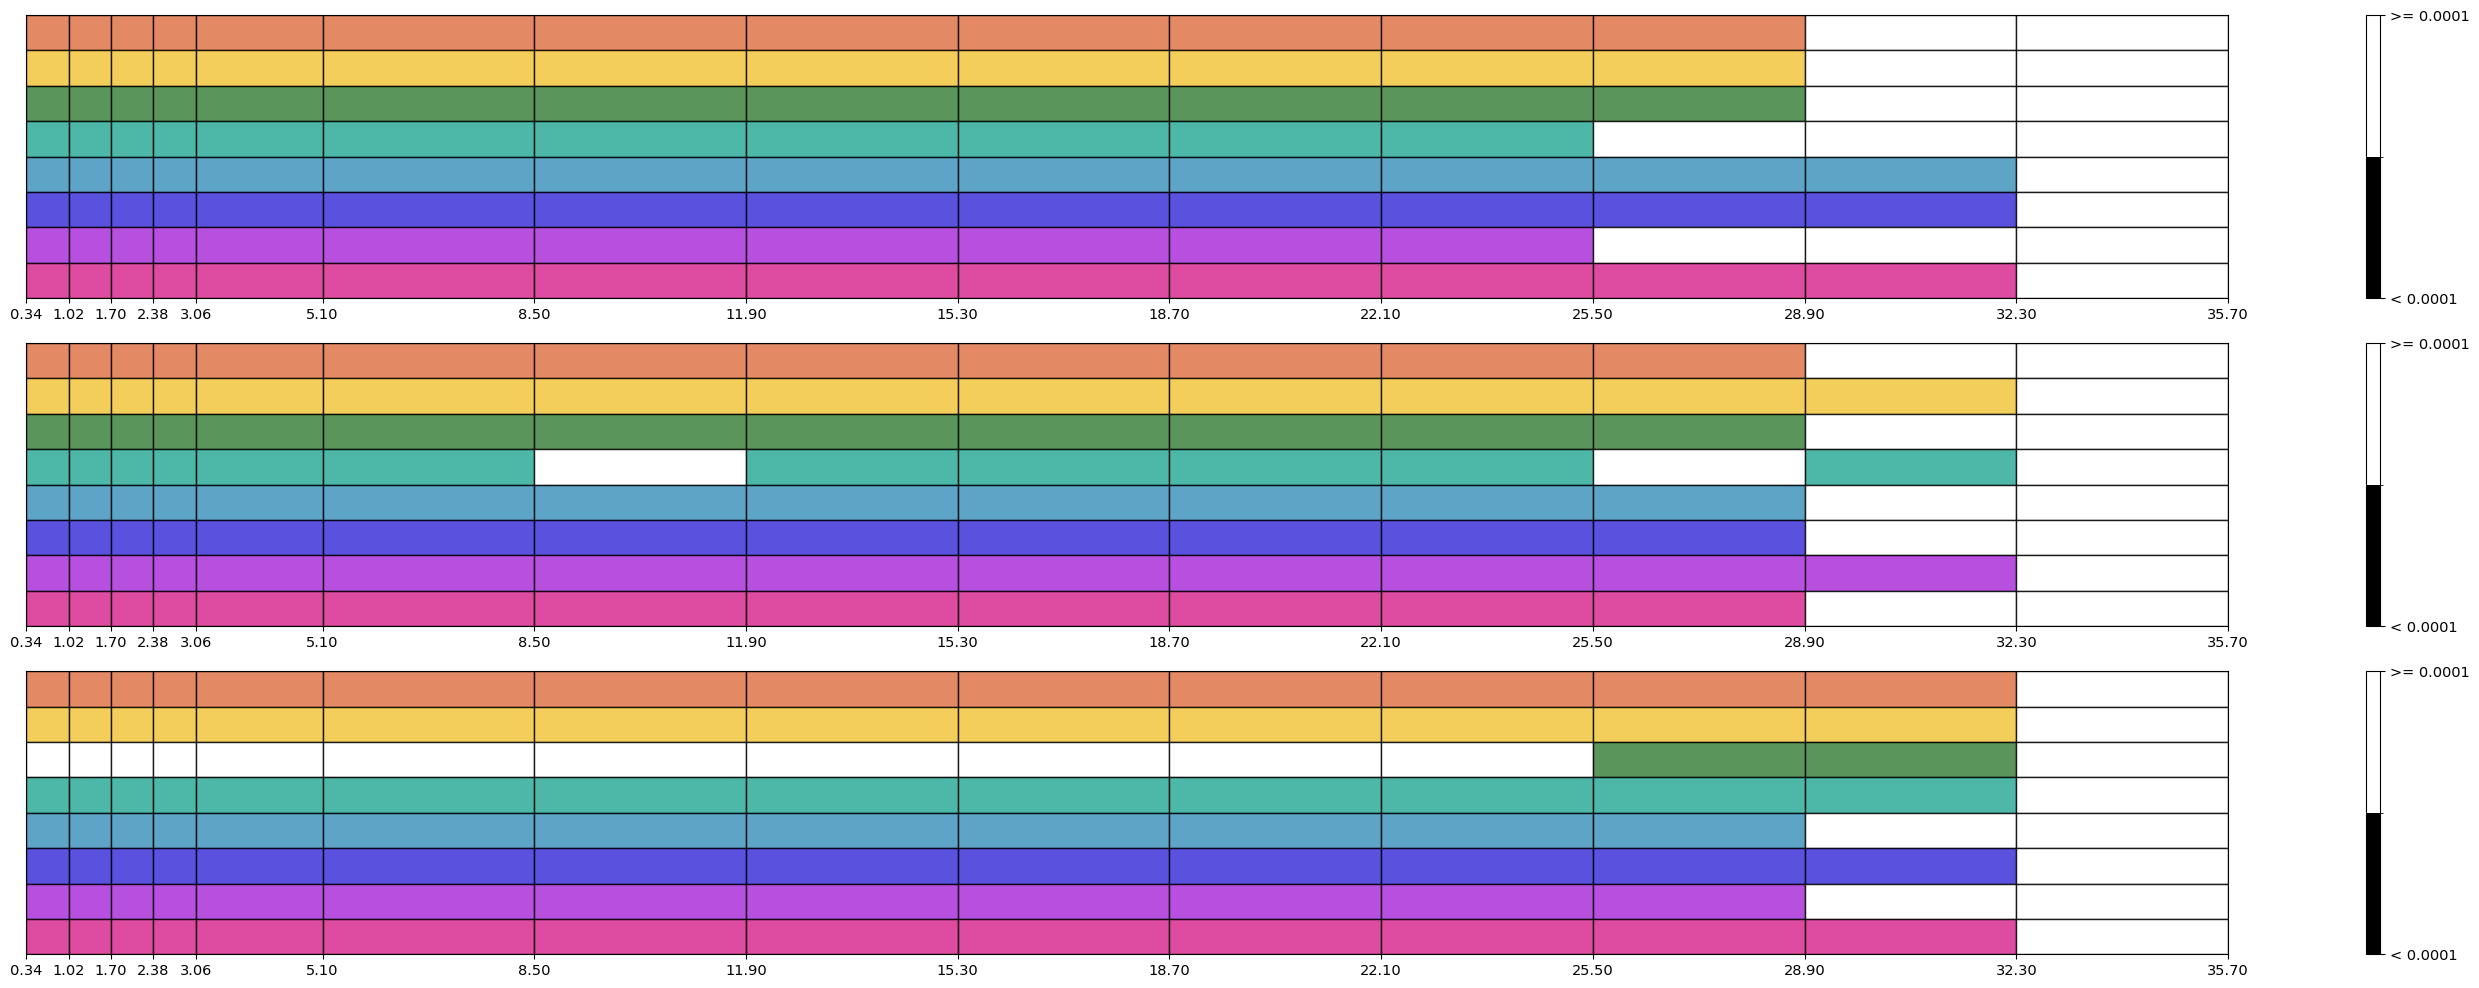

NameError: name 'adslkfjadskl' is not defined

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap, BoundaryNorm

# Calculate the edges of the bins based on the bin centers
bin_edges = np.zeros(len(ts_bin_centers) + 1)
bin_edges[1:-1] = (ts_bin_centers[1:] + ts_bin_centers[:-1]) / 2
bin_edges[0] = ts_bin_centers[0] - (ts_bin_centers[1] - ts_bin_centers[0]) / 2
bin_edges[-1] = ts_bin_centers[-1] + (ts_bin_centers[-1] - ts_bin_centers[-2]) / 2

# Create heatmaps
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(28, 10))
axes = axes.flatten()

# Create a custom colormap: black for values < 0.0001, white for values >= 0.0001
cmap = ListedColormap(['black', 'white'])
norm = BoundaryNorm([0, 0.0001, 1], cmap.N)

for i in range(3):
    ax = axes[i]
    data = ts_stats[i,:,:]
    
    # Apply the custom color mapping
    color_data = np.where(data < 0.0001, 0, 1)
    
    # Create a meshgrid for pcolormesh
    X, Y = np.meshgrid(bin_edges, np.arange(data.shape[0] + 1))
    
    # Plot the heatmap
    for row in range(data.shape[0]):
        for col in range(data.shape[1]):
            color = cols[row] if data[row, col] < 0.0001 else 'white'
            ax.add_patch(plt.Rectangle((bin_edges[col], row), bin_edges[col+1]-bin_edges[col], 1, facecolor=color, alpha=0.8, edgecolor='black'))
    
    ax.set_xlim(bin_edges[0], bin_edges[-1])
    ax.set_ylim(0, data.shape[0])
    ax.set_yticks([])
    ax.set_xticks(bin_edges)
    ax.invert_yaxis()
    
    # Add a colorbar
    cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, orientation='vertical', ticks=[0, 1])
    cbar.ax.set_yticklabels(['< 0.0001', '>= 0.0001'])

plt.tight_layout()
plt.show()
#fig.savefig(FIG_FOLDER+'/trainRatio_pvals.png', dpi=600, bbox_inches='tight')

print(adslkfjadskl)
# NEURONAL POPULATION SIZE 

# Calculate the edges of the bins based on the bin centers
bin_edges = np.zeros(len(nn_bin_centers) + 1)
bin_edges[1:-1] = (nn_bin_centers[1:] + nn_bin_centers[:-1]) / 2
bin_edges[0] = nn_bin_centers[0] - (nn_bin_centers[1] - nn_bin_centers[0]) / 2
bin_edges[-1] = nn_bin_centers[-1] + (nn_bin_centers[-1] - nn_bin_centers[-2]) / 2

# Create heatmaps
fig2, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 10))
axes = axes.flatten()

for i in range(3):
    ax = axes[i]
    data = nn_stats[i,:,:]
    
    # Apply the custom color mapping
    color_data = np.where(data < 0.0001, 0, 1)
    
    # Create a meshgrid for pcolormesh
    X, Y = np.meshgrid(bin_edges, np.arange(data.shape[0] + 1))
    
    # Plot the heatmap
    for row in range(data.shape[0]):
        for col in range(data.shape[1]):
            color = cols[row] if data[row, col] < 0.0001 else 'white'
            ax.add_patch(plt.Rectangle((bin_edges[col], row), bin_edges[col+1]-bin_edges[col], 1, facecolor=color, alpha = 0.8, edgecolor='black'))
    
    ax.set_xlim(bin_edges[0], bin_edges[-1])
    ax.set_ylim(0, data.shape[0])
    ax.set_yticks([])
    ax.set_xticks([])
    ax.invert_yaxis()
    
    # Add a colorbar
    cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, orientation='vertical', ticks=[0, 1])
    cbar.ax.set_yticklabels(['< 0.0001', '>= 0.0001'])

plt.tight_layout()
plt.show()
fig2.savefig(FIG_FOLDER+'/numNeurons_pvals.png', dpi=300, bbox_inches='tight')

# Figure 6. FORMAT of data (input bin width & temporal context)

In [ ]:
column_names = ['line','sess','timePrePost','output_binWidth','downsample_factor','input_timeWindow','input_binWidth','numNeurons','nMT','nFEF','outer_fold','repeat','trainRatio','numObservations','output','model','prms','preProcess_time','train_time','test_time','R2_train','rho_train','rmse_train','R2_test','rho_test','rmse_test']
df, _ = get_outputs(DATA_FOLDER,["s29"],column_names,lrange=[1680,9023],withTraces=False) # position

df.head(1)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from sklearn.preprocessing import MinMaxScaler
from matplotlib.colors import TwoSlopeNorm
import matplotlib.ticker as ticker

# Define the desired number of bins in x and y axes
desired_x_bins = 9
desired_y_bins = 9
mdls = ['wf', 'wc', 'kf', 'xgb', 'svr', 'dnn', 'rnn', 'gru', 'lstm']
beh = 'R2_test_mn'
cutType = 0

def gaussian(M, x0, y0, xalpha, yalpha, A):
    x, y = M
    return A * np.exp(-(((x - x0) / xalpha) ** 2 + ((y - y0) / yalpha) ** 2) / 2).ravel()

plt.rcParams.update({'font.size': 11})
fig, ax = plt.subplots(len(df['model'].unique()), len(df['output'].unique()), figsize=(7, 20), sharex=True, sharey=True)
fig.tight_layout()

for col, kin in enumerate(df['output'].unique()):    
    for i, m in enumerate(df['model'].unique()):
        DF = df.loc[(df['model'] == m) & (df['output'] == kin)]
        dff = DF[[beh, 'input_binWidth', 'input_timeWindow']]
        
        if cutType == 0:
            df_m = dff.groupby([
                pd.qcut(dff['input_binWidth'], q=desired_x_bins, duplicates='drop'),
                pd.qcut(dff['input_timeWindow'], q=desired_y_bins, duplicates='drop')
            ])[beh].mean().reset_index(name="R2")
        else:
            df_m = dff.groupby([
                pd.cut(dff['input_binWidth'], bins=desired_x_bins),
                pd.cut(dff['input_timeWindow'], bins=desired_y_bins)
            ])[beh].mean().reset_index(name="R2")

        # Pivot the data for heatmap
        result = df_m.pivot(index='input_timeWindow', columns='input_binWidth', values='R2')
        
        R2_values = result.values.astype(float)
        # Calculate mean of non-normalized values
        mean_value_non_normalized = np.nanmean(R2_values)
        
        # Normalize the values using Min-Max scaler
        scaler = MinMaxScaler()
        normalized_values = scaler.fit_transform(R2_values)
        
        # Create a DataFrame to hold normalized values while preserving NaNs
        result2 = result.copy()
        result2.loc[:, :] = normalized_values
        
        # Create a mask for NaN values
        mask = result.isnull()

        # Use the original colormap
        cmap = pals[i]
        # Normalize colormap around 0.45
        norm = TwoSlopeNorm(vmin=0, vcenter=0.5, vmax=1)
        
        # Calculate bin edges for pcolormesh
        x_edges = [col.left for col in result.columns] + [result.columns[-1].right]
        y_edges = [index.left for index in result.index] + [result.index[-1].right]
        
        # Create a custom heatmap with pcolormesh
        mesh = ax[i, col].pcolormesh(x_edges, y_edges, result2, cmap=cmap, norm=norm, shading='auto', edgecolors='none')
        
        # Map Gaussian fitting to the actual heatmap coordinates
        X, Y = np.meshgrid(x_edges[:-1], y_edges[:-1])
        
        # Mask out NaN values
        valid_mask = ~np.isnan(normalized_values)
        valid_x = X[valid_mask]
        valid_y = Y[valid_mask]
        valid_z = normalized_values[valid_mask]

        # Better initial guess based on data statistics
        initial_guess = (
            (x_edges[-1] - x_edges[0]) / 2, 
            (y_edges[-1] - y_edges[0]) / 2, 
            np.std(valid_x), 
            np.std(valid_y), 
            np.max(valid_z)
        )
        
        # Define bounds for the parameters
        bounds = (
            (x_edges[0], y_edges[0], 0, 0, 0),  # Lower bounds
            (x_edges[-1], y_edges[-1], np.inf, np.inf, np.inf)  # Upper bounds
        )
        
        try:
            popt, _ = curve_fit(
                gaussian, (valid_x, valid_y), valid_z.ravel(), 
                p0=initial_guess, bounds=bounds, maxfev=10000
            )

            fitted_data = gaussian((X, Y), *popt).reshape(normalized_values.shape)
            
            # Calculate the mesh grid for plotting contours over the entire heatmap
            x_contour, y_contour = np.meshgrid(
                np.linspace(x_edges[0], x_edges[-1], 100),
                np.linspace(y_edges[0], y_edges[-1], 100)
            )
            fitted_data_contour = gaussian((x_contour, y_contour), *popt).reshape(x_contour.shape)
            
            ax[i, col].contour(x_contour, y_contour, fitted_data_contour, colors='lightgray')

            # Get the fit parameters
            x0, y0, xalpha, yalpha, A = popt
            
            # Ensure x0 and y0 are within the bounds
            x0 = np.clip(x0, x_edges[0], x_edges[-1])
            y0 = np.clip(y0, y_edges[0], y_edges[-1])
            
            # Calculate significance (e.g., variance explained by the Gaussian fit)
            residuals = valid_z - gaussian((valid_x, valid_y), *popt)
            ss_res = np.sum(residuals**2)
            ss_tot = np.sum((valid_z - np.mean(valid_z))**2)
            r_squared = 1 - (ss_res / ss_tot)

            ax[i, col].plot(x0, y0, 'o', markersize=8, color='white', markeredgecolor='white')

            # Set the title with Gaussian parameters and significance, formatted into two lines
            #ax[i, col].set_title(f'$x_{{0}}$: {x0:.0f}, $y_{{0}}$: {y0:.0f}, R²: {r_squared:.2f}', fontsize=12, color=[0.3,0.3,0.3])
            ax[i, col].set_title(f'$\\mathbf{{R^{{2}}_{{\mathrm{{gaussian}}}}}}$: {r_squared:.2f}', fontsize=10.5, color=[0.3,0.3,0.3])
            
        except RuntimeError as e:
            print(f"Fit could not be found for model {m} and output {kin}: {e}")
            ax[i, col].set_title(f'Fit Failed', fontsize=10)

        ax[i, col].invert_yaxis()
        ax[i, col].set_xticks([10,20,30,40,60,90,130,200,300])
        ax[i, col].set_yticks([10,140,240,326,431,528,623,720,811,900])
        ax[i, col].set_xticklabels(['10','','','','60','','130','200','300'])
        ax[i, col].set_yticklabels(['10','140','','326','','528','','720','','900'])

        ax[i, col].set(xlabel=None)
        ax[i, col].set(ylabel=None)

        # Add a vertical colorbar to the right of each subplot
        cbar = plt.colorbar(mesh, ax=ax[i, col], orientation='vertical', pad=0.01, shrink=0.7)
        cbar.set_ticks([0, 1])
        cbar.set_ticklabels([np.round(np.nanmin(result.values.astype(float)),2), np.round(np.nanmax(result.values.astype(float)),2)])
        cbar.outline.set_visible(False)
        cbar.ax.tick_params(labelsize=11)
        
        # Remove the axes while keeping the ticks
        ax[i, col].spines['top'].set_visible(False)
        ax[i, col].spines['right'].set_visible(False)
        ax[i, col].spines['left'].set_visible(False)
        ax[i, col].spines['bottom'].set_visible(False)

plt.subplots_adjust(wspace=0.25, hspace=0.3)
fig.savefig(FIG_FOLDER+'/dti_heatmaps_wgauss_varWidth.png', dpi=300, bbox_inches='tight')

# Figure 7. FORMAT of data (output bin width)

In [13]:
if 'plot_trials' not in locals(): 
    column_names = ['line','sess','timePrePost','output_binWidth','downsample_factor','input_timeWindow','input_binWidth','numNeurons','nMT','nFEF','outer_fold','repeat','trainRatio','numObservations','output','model','prms','preProcess_time','train_time','test_time','R2_train','rho_train','rmse_train','R2_test','rho_test','rmse_test']
    df, yp_test = get_outputs(DATA_FOLDER,["s29","r0001"],column_names,lrange=[0,239],withTraces=True) # position
    ya_test, c_test = get_actualTraces(DATA_FOLDER, df)

    # Get trial numbers for "best" trial in each direction, will be used for all eye traces plots
    #plot_trls = get_exTrialLabels(df,c_test,ya_test,yp_test,o='position',fold=0,mdl=7,gi=13)
    plot_trls = get_exTrialLabels(df,c_test,ya_test,yp_test,fold=0,o='acceleration',gi=1)
    print(plot_trls)
    
column_names = ['line','sess','timePrePost','output_binWidth','downsample_factor','input_timeWindow','input_binWidth','numNeurons','nMT','nFEF','outer_fold','repeat','trainRatio','numObservations','output','model','prms','preProcess_time','train_time','test_time','R2_train','rho_train','rmse_train','R2_test','rho_test','rmse_test']
df, yp_test = get_outputs(DATA_FOLDER,["s29"],column_names,lrange=[960,1679],withTraces=True) # position
ya_test, c_test = get_actualTraces(DATA_FOLDER, df)

df.head(1)

[1068, 912, 938, 1015]


,line,sess,timePrePost,output_binWidth,downsample_factor,input_timeWindow,input_binWidth,numNeurons,nMT,nFEF,...,rmse_train,R2_test,rho_test,rmse_test,R2_test_mn,rho_test_mn,rmse_test_mn,R2_train_mn,rho_train_mn,rmse_train_mn
0,960,29,0,10,1,400,50,65,24,41,...,"[2.542401093215621, 2.556934027092868]","[0.7063171623963362, 0.768587937204791]","[[0.8408104808807414, 0.8784322685462637]]","[2.632778748648657, 2.538956651771066]",0.737453,0.859621,2.585868,0.739657,0.859955,2.549668


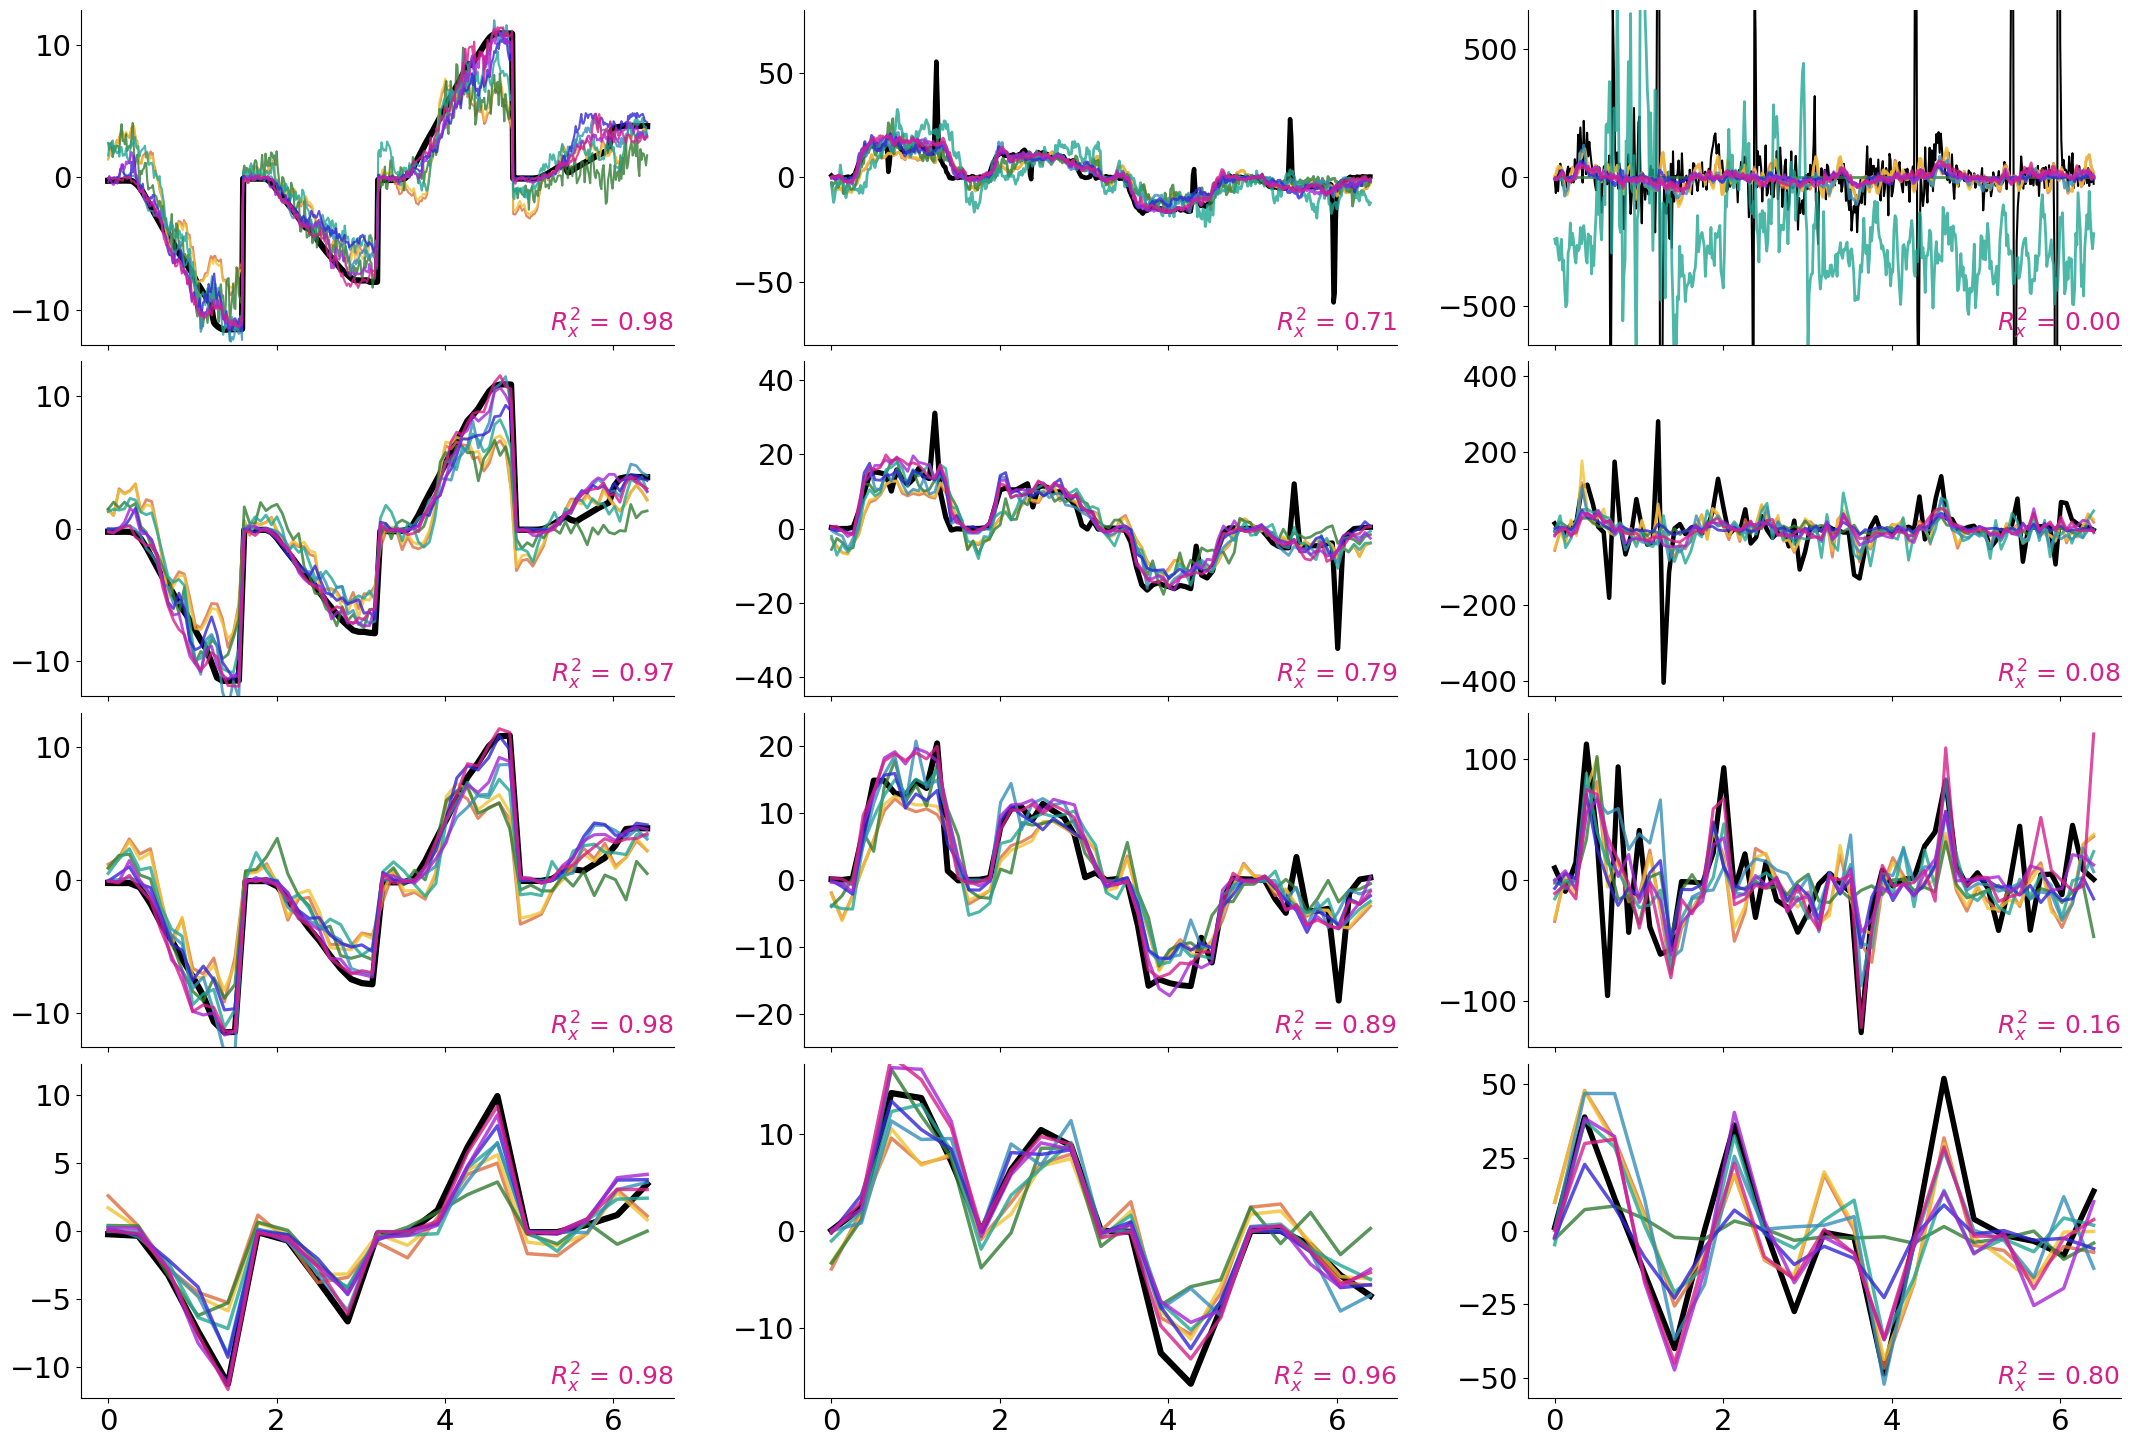

In [14]:
bws = [10,50,100,300]
lws = [[1.5,2,2],[2,2,2],[2.25,2.25,2.25],[2.5,2.5,2.5]]
tws = [[4.5,3.25,1.5],[4.5,3.75,3.25],[4.5,4.25,3.75],[4.5,4.5,4]]

plt.rcParams.update({'font.size': 21})
fig, axes = plt.subplots(len(bws),3,figsize=(22,15), sharex=True, sharey=False)#,gridspec_kw={'height_ratios': [2,2,0.3,2,2,0.3,2,2]})
fig.tight_layout()

for b, bw in enumerate(bws):
    for c, kin in enumerate(df['output'].unique()):
        for r, mod in enumerate(df['model'].unique()):
            y_true, y_pred = get_eyeTraces(df,c_test,ya_test,yp_test,dto=bw,o=kin,mdl=mod,fold=0,trls=sorted(plot_trls))
            x = np.linspace(0,4*1.6,y_true.shape[0])

            if r==0:
                axes[b,c].plot(x,y_true[:,0],linewidth=tws[b][c],linestyle='solid',alpha=1,color=(0,0,0),zorder=0)
                #axes[b,c].plot(x,y_true[:,1],linewidth=lws[c],linestyle='dashed',color=(0.6,0.6,0.6))

            #if mod==3:
            #    axes[r,c].plot(x,y_pred[:,0]*np.std(y_true[:,0]),linewidth=lws[c],linestyle='solid',color=cols[r])
            #    axes[r,c].plot(x,y_pred[:,1]*np.std(y_true[:,1]),linewidth=lws[c],linestyle='dashed',color=cols[r])

            #    r2 = get_R2(y_true,y_pred * np.std(y_true,axis=0))

            #else:
            
            axes[b,c].plot(x,y_pred[:,0],linewidth=lws[b][c],linestyle='solid',color=cols[r],alpha=0.8,zorder=1)
            #axes[b,c].plot(x,y_pred[:,1],linewidth=lws[c],linestyle='dashed',color=cols[r])

            r2 = get_R2(y_true,y_pred)
            
            if mod==7:
                text_box = f"$R^2_x$ = {r2[0]:.2f}"
                axes[b,c].text(1, 0.01, text_box, transform=axes[b,c].transAxes, fontsize=18, ha='right', va='bottom', color=cols[r])

            axes[b,c].spines['right'].set_color('none')
            #axes[i].spines['bottom'].set_color('none')
            axes[b,c].spines['top'].set_color('none')
                
            # Set the y-axis limits to be centered on 0
            y_min, y_max = axes[b,c].get_ylim()
            max_abs_value = max(abs(y_min), abs(y_max))
            axes[b,c].set_ylim(-max_abs_value, max_abs_value)

axes[0,0].set_xticks([0,2,4,6])
axes[0,1].set_ylim([-80,80])
axes[1,1].set_ylim([-45,45])
axes[2,1].set_ylim([-25,25])
axes[0,2].set_ylim([-650,650])
#axes[0,0].set_xticks([0.6])
            
plt.subplots_adjust(wspace=0.22, hspace=0.05)
fig.savefig(FIG_FOLDER+'/dtoTraces_8models_r2x.png', dpi=300, bbox_inches='tight')
    

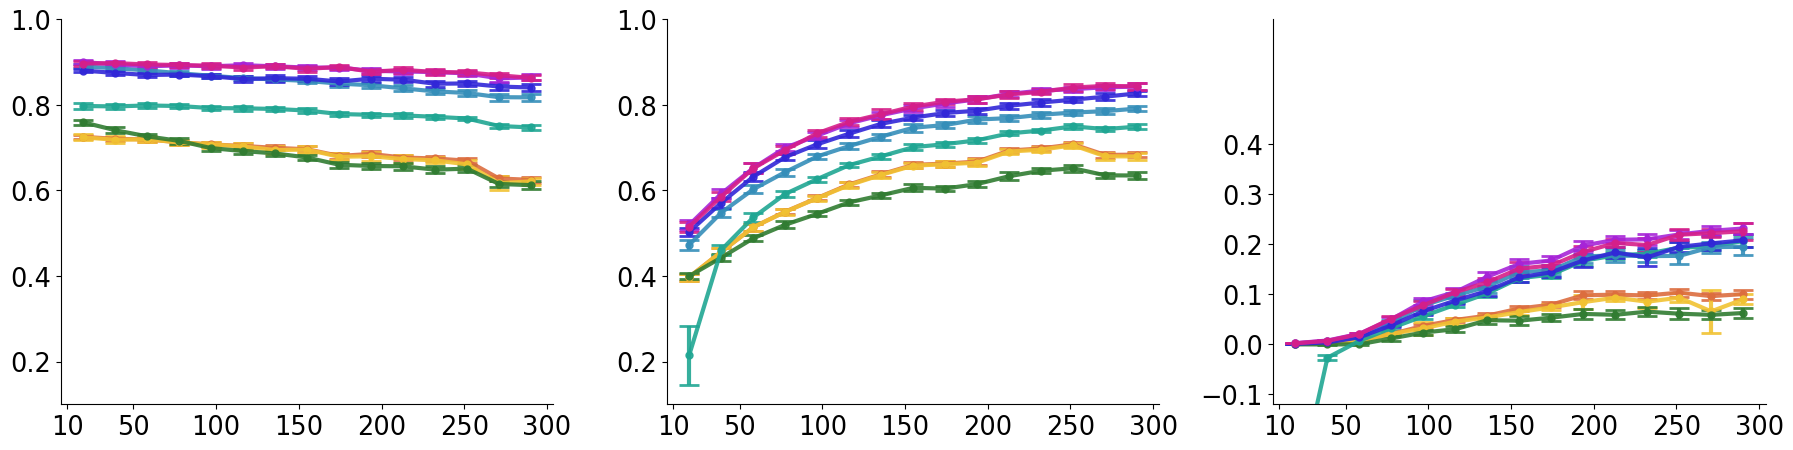

In [21]:
import matplotlib.ticker as ticker

plt.rcParams.update({'font.size': 18.5})
fig, ax = plt.subplots(1, 3, figsize=(22, 5), sharex=True, sharey=False)#, gridspec_kw={'height_ratios': [3, 2]})

#plt.subplots_adjust(hspace=0.1)

################################### training set size ############################
kins = ['position','velocity','acceleration']
behs = ['R2_test_mn']
num_bins = 15

for k, kin in enumerate(kins):
    for b, beh in enumerate(behs):
        dff = df.loc[(df['output']==kin)]
        dff = dff.copy()
        
        #dff = dff[dff[beh] >= -10]

        dff = dff[['model', 'output_binWidth', beh, 'outer_fold','repeat']]
        dff = dff.groupby(['model', 'output_binWidth', 'outer_fold'])[beh].mean().reset_index()
        obw = dff['output_binWidth'].unique()

        #df_mn = dff.groupby(['model', pd.qcut(dff['trainSet_size'], num_bins)])[beh].mean().reset_index(name="mR2")
        #df_sd = dff.groupby(['model', pd.qcut(dff['trainSet_size'], num_bins)])[beh].std().reset_index(name="sR2")

        df_mn = dff.groupby(['model', pd.cut(dff['output_binWidth'], bins=num_bins)])[beh].mean().reset_index(name="mR2")
        df_sd = dff.groupby(['model', pd.cut(dff['output_binWidth'], bins=num_bins)])[beh].std().reset_index(name="sR2")

        # Group by 'model' and 'output_binWidth', and print the sample counts for each group
        df_counts = dff.groupby(['model', pd.cut(dff['output_binWidth'], bins=num_bins)]).size().reset_index(name="count")

        # Printing the number of samples in each group
        for index, row in df_counts.iterrows():
            print(f"Model: {row['model']}, Output bin: {row['output_binWidth']}, Count: {row['count']}")
        
        #df_mn = dff.groupby(['model', 'output_binWidth'])[beh].mean().reset_index(name="mR2")
        #df_sd = dff.groupby(['model', 'output_binWidth'])[beh].std().reset_index(name="sR2")
        
        #df_mn = dff.groupby(['model', 'trainSet_size'])[beh].mean().reset_index(name="mR2")
        #df_sd = dff.groupby(['model', 'trainSet_size'])[beh].std().reset_index(name="sR2")

        for i,m in enumerate(df['model'].unique()):
            if m < 9:
                mod_mn = df_mn[(df_mn['model'] == m)]['mR2'].values
                mod_sd = (df_sd[(df_sd['model'] == m)]['sR2'].values) * np.sqrt(1. / 10 + 1. / (10 - 1))

                bin_centers = [bin.mid for bin in df_mn[(df_mn['model'] == m)]['output_binWidth']]
                #bin_centers = obw
                
                ax[k].errorbar(bin_centers, mod_mn, mod_sd, lw=3, capsize=7, marker='o', alpha=0.9, markersize=5, capthick=2, color=cols[i], zorder=3)   
                
                #ax[k,0].set_xscale('log')  # Set x-axis to log scale
                #ax[k,0].set_yscale('log')  # Set y-axis to log scale
                
                #x_tick_labels = [int(center) for center in bin_centers]
                #ax[k,0].set_xticks(bin_centers)
                #ax[k,0].set_xticklabels(x_tick_labels, rotation=0)
                
                #ax[k,0].set_xticks([0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100])
                #ax[k,0].set_xticklabels(['0','','10','','20','','','','40','','','','60','','','','80','','','','100'])
                
                # Set the x-tick labels as bin minimum and maximum for each point
                #x_tick_labels = obw
                ax[k].set_xticks([10,50,100,150,200,250,300])
                #ax[k].set_xticklabels([0,20,40,60,80,100], rotation=0)
                #

    ax[k].spines['right'].set_color('none')
    ax[k].spines['top'].set_color('none')
    
ax[0].set_ylim([0.1,1])
ax[1].set_ylim([0.1,1])
ax[2].set_ylim([-0.12,0.65])

ax[0].set_yticks([0.2,0.4,0.6,0.8,1.0])
ax[1].set_yticks([0.2,0.4,0.6,0.8,1.0])
ax[2].set_yticks([-0.1,0,0.1,0.2,0.3,0.4])
    
plt.subplots_adjust(wspace=0.23, hspace=0.05)
#fig.savefig(FIG_FOLDER+'/dto_8models_r2.png', dpi=300, bbox_inches='tight')

In [ ]:
# stats
from statsmodels.stats.anova import AnovaRM

num_bins = 15
kins = ['position', 'velocity', 'acceleration']

for k, kin in enumerate(kins):
    for i,m in enumerate(df['model'].unique()):
        DF = df.loc[(df['output'] == kin) & (df['model'] == m) & (df['output_binWidth']!=0) & (df['R2_test_mn'] >-1)]
        df_mn = DF.groupby([pd.cut(dff['output_binWidth'], bins=num_bins), 'outer_fold'])['R2_test_mn'].mean().reset_index()
        
        anova_model = AnovaRM(df_mn, 'R2_test_mn', 'outer_fold', within=['output_binWidth'])
        
        results = anova_model.fit()
        print('{}-{}'.format(kin,m))
        print(results)
        
        min_max_r2_values = df_mn.groupby('output_binWidth')['R2_test_mn'].agg(['min', 'max'])
        print(min_max_r2_values)

        # Extract the 'R2_mn' values for the smallest and largest 'output_binWidth'
        min_r2 = min_max_r2_values.loc[min_max_r2_values['R2_test_mn'].idxmin()]['R2_test_mn']
        max_r2 = min_max_r2_values.loc[min_max_r2_values['R2_test_mn'].idxmax()]['R2_test_mn']

        # Calculate the percent difference
        percent_difference = ((max_r2 - min_r2) / min_r2) * 100

        print(average_percent_difference)

        #df_sd = dff.groupby(['model', pd.cut(dff['output_binWidth'], bins=num_bins)])[beh].std().reset_index(name="sR2"

# Figure 8. Computational load and robustness

In [22]:
column_names = ['line','sess','timePrePost','output_binWidth','downsample_factor','input_timeWindow','input_binWidth','numNeurons','nMT','nFEF','outer_fold','repeat','trainRatio','numObservations','output','model','prms','preProcess_time','train_time','test_time','R2_train','rho_train','rmse_train','R2_test','rho_test','rmse_test']
df1, _ = get_outputs(DATA_FOLDER,["s29"],column_names,lrange=[240,575], withTraces=False) # trainSize
df2, _ = get_outputs(DATA_FOLDER,["s29"],column_names,lrange=[576,959], withTraces=False) # numNeurons
df3, _ = get_outputs(DATA_FOLDER,["s29"],column_names,lrange=[960,1679], withTraces=False) # outBins
df4, _ = get_outputs(DATA_FOLDER,["s29"],column_names,lrange=[1680,9023], withTraces=False) # inBins

maxTime = int((np.unique(df1['numObservations']).max()) * (5/100) * (1/60))
maxTime

df1.head(3)

,line,sess,timePrePost,output_binWidth,downsample_factor,input_timeWindow,input_binWidth,numNeurons,nMT,nFEF,...,rmse_train,R2_test,rho_test,rmse_test,R2_test_mn,rho_test_mn,rmse_test_mn,R2_train_mn,rho_train_mn,rmse_train_mn
0,240,29,0,50,1,400,50,65,24,41,...,"[2.531397115853775, 2.535408542798284]","[0.6967174842812607, 0.7644170094397259]","[[0.8351590899362646, 0.8757743752053939]]","[2.6307275790573037, 2.5191258599695905]",0.730567,0.855467,2.574927,0.734125,0.856719,2.533403
1,240,29,0,50,1,400,50,65,24,41,...,"[2.523750275257502, 2.5343818001354315]","[0.6802569482005802, 0.7601311296566597]","[[0.8347804300673947, 0.8724204991320531]]","[2.693021762498249, 2.539350074554998]",0.720194,0.853600,2.616186,0.735837,0.857728,2.529066
2,240,29,0,50,1,400,50,65,24,41,...,"[2.5374785155470865, 2.5301053254158528]","[0.7072641973421873, 0.7534570128261007]","[[0.8464654241912434, 0.8749482222381165]]","[2.555384524576792, 2.5236440814437304]",0.730361,0.860707,2.539514,0.735455,0.857484,2.533792


In [160]:
from scipy.stats import linregress, pearsonr

def correlation_to_lw(df1,df2,df3,df4):
    behs = ['train_time','test_time','robust_diff','rmse_test_mn','rho_test_mn']
    varbls = ['trainRatio','numNeurons','input_binWidth','input_timeWindow','output_binWidth']
    kins = ['position']
    
    corrs = np.zeros((len(behs),8,len(varbls)))
    pvals = np.zeros((len(behs),8,len(varbls)))
    slopes = np.zeros((len(behs),8,len(varbls)))
    r2s = np.zeros((len(behs),8,len(varbls)))
    for v, vr in enumerate(varbls):
        if v==0:
            ddf = df1
        elif v==1:
            ddf = df2
        elif v==2:
            ddf = df4.loc[df4['input_timeWindow'].isin([900])] #600,720,840,900
        elif v==3:
            ddf = df4.loc[df4['input_binWidth']==20]
        else:
            ddf = df3

        ddf = calc_evalMetrics(ddf,-10000)

        df = ddf.loc[ddf['output']=='position']

        for b, beh in enumerate(behs):
            for i,m in enumerate(df['model'].unique()):
                data_var = df.loc[df['model'] == m][vr].values
                eval_var = df.loc[df['model'] == m][beh].values

                corr, p_value = pearsonr(data_var, eval_var)
                corrs[b,i,v] = np.abs(corr)
                pvals[b,i,v] = p_value

                # Linear regression
                slope, intercept, r_value, p_value_reg, std_err = linregress(data_var, eval_var)
                r_squared = r_value**2
                slopes[b,i,v] = np.abs(slope)
                r2s[b,i,v] = r_squared

    #print(np.mean(corrs,axis=1))
    #print(np.mean(slopes,axis=1))
    lws = np.ones_like(r2s)
    for vv in range(len(behs)):
        max_ems = corrs[vv].argmax(axis=1)
        for mm in range(8):
            lws[vv][mm][max_ems[mm]] = 4

    return lws,pvals

Model: 0, Group: (0.019, 0.0571], Count: 2000
Model: 0, Group: (0.0571, 0.0943], Count: 2000
Model: 0, Group: (0.0943, 0.257], Count: 2000
Model: 0, Group: (0.257, 0.443], Count: 2000
Model: 0, Group: (0.443, 0.629], Count: 2000
Model: 0, Group: (0.629, 0.814], Count: 2000
Model: 0, Group: (0.814, 1.0], Count: 2000
Model: 1, Group: (0.019, 0.0571], Count: 2000
Model: 1, Group: (0.0571, 0.0943], Count: 2000
Model: 1, Group: (0.0943, 0.257], Count: 2000
Model: 1, Group: (0.257, 0.443], Count: 2000
Model: 1, Group: (0.443, 0.629], Count: 2000
Model: 1, Group: (0.629, 0.814], Count: 2000
Model: 1, Group: (0.814, 1.0], Count: 2000
Model: 2, Group: (0.019, 0.0571], Count: 2000
Model: 2, Group: (0.0571, 0.0943], Count: 2000
Model: 2, Group: (0.0943, 0.257], Count: 2000
Model: 2, Group: (0.257, 0.443], Count: 2000
Model: 2, Group: (0.443, 0.629], Count: 2000
Model: 2, Group: (0.629, 0.814], Count: 2000
Model: 2, Group: (0.814, 1.0], Count: 2000
Model: 3, Group: (0.019, 0.0571], Count: 2000
Mod

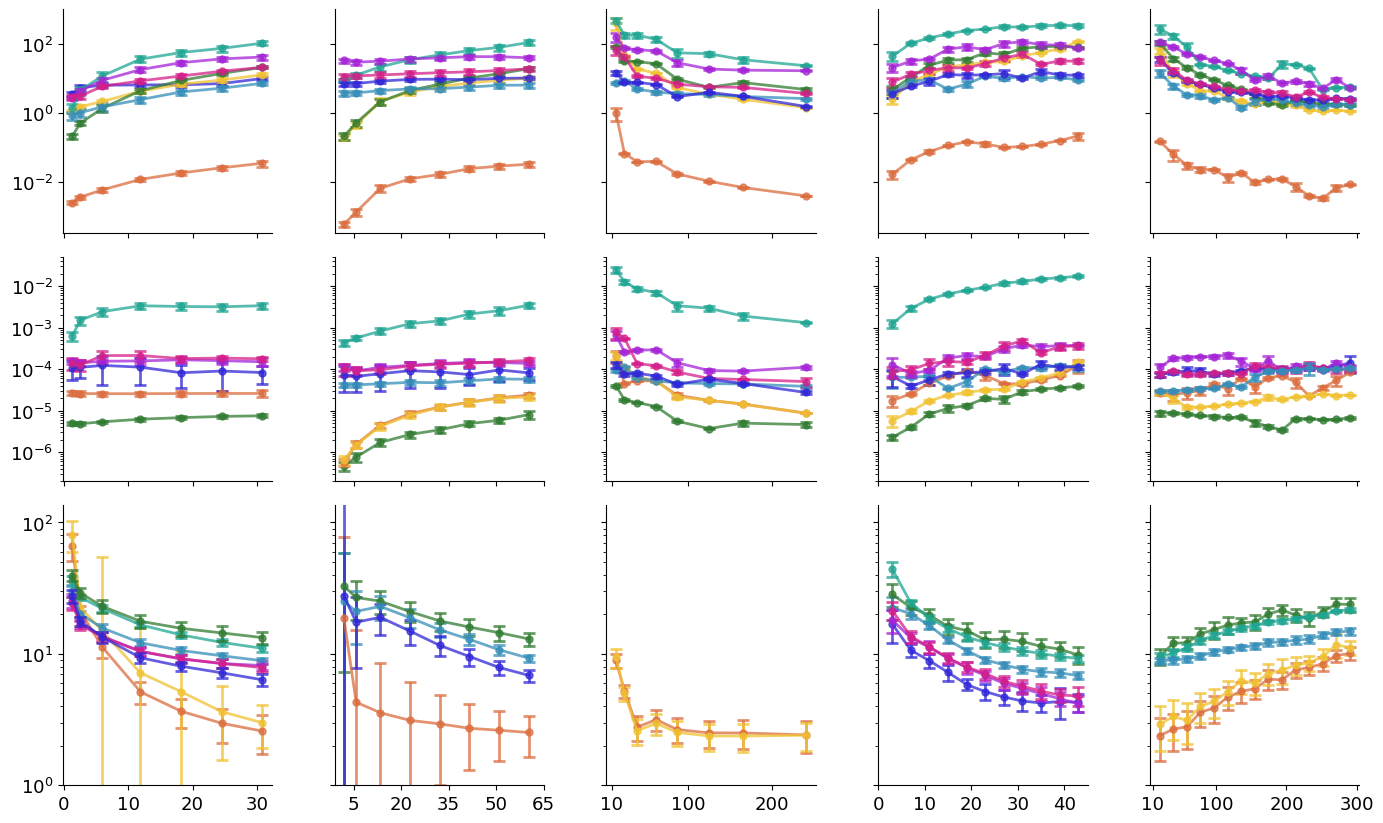

In [161]:
lws,pvals = correlation_to_lw(df1,df2,df3,df4)

behs = ['train_time','test_time','robust_diff']
varbls = ['trainRatio','numNeurons','input_binWidth','num_feat','output_binWidth']
kins = ['position']

plt.rcParams.update({'font.size': 13})
fig, ax = plt.subplots(len(behs), len(varbls), figsize=(14, 8.5), sharex='col', sharey='row', gridspec_kw={'height_ratios': [2,2,2.5]})
fig.tight_layout()

for v, vr in enumerate(varbls):
    if v==0:
        ddf = df1
        num_bins = 7
    elif v==1:
        ddf = df2
        num_bins = 8
    elif v==2:
        ddf = df4.loc[df4['input_timeWindow'].isin([900])] #600,720,840,900
        num_bins = 8
    elif v==3:
        ddf = df4.loc[df4['input_binWidth']==20]
        num_bins = 11
    else:
        ddf = df3
        num_bins = 15
        
    ddf = calc_evalMetrics(ddf,-1000000000000)
        
    for k, kin in enumerate(kins):
        df = ddf.loc[ddf['output']==kin]

        for b, beh in enumerate(behs):
            dff = df[['model', vr, beh, 'outer_fold']]
            obw = dff[vr].unique()
            
            # Group by 'model' and 'output_binWidth', and print the sample counts for each group
            df_counts = dff.groupby(['model', vr]).size().reset_index(name="count")
            
            # Find the maximum number of samples across all groups
            max_count = df_counts['count'].max()
        

            # Iterate through each row in df_counts
            if max_count != 10:
                for index, row in df_counts.iterrows():
                    if row['count'] == 10:
                        # If the count is 10, repeat the rows enough times to reach 1000 samples
                        filtered_data = dff[(dff['model'] == row['model']) & (dff[vr] == row[vr])]
                        repeat_factor = int(1000 // int(row['count'])) - 1
                        repeated_data = pd.concat([filtered_data] * repeat_factor, ignore_index=True)
                        dff = pd.concat([dff, repeated_data], ignore_index=True)

                    elif row['count'] < max_count :
                        # If the count is less than the maximum but more than 10, resample to match max_count
                        filtered_data = dff[(dff['model'] == row['model']) & (dff[vr] == row[vr])]
                        resampled_data = filtered_data.sample(n=max_count, replace=True, random_state=42)
                        dff = pd.concat([dff, resampled_data], ignore_index=True)

            # At this point, all groups in dff should have the same number of samples (max_count or 1000 where applicable)
                    
            df_counts = dff.groupby(['model', pd.qcut(dff[vr], num_bins)]).size().reset_index(name="count")
            
            # Printing the number of samples in each group
            if b==0:
                for index, row in df_counts.iterrows():
                    print(f"Model: {row['model']}, Group: {row[vr]}, Count: {row['count']}")

                print('-------------------')
            
            
            df_mn = dff.groupby(['model', pd.qcut(dff[vr], num_bins)])[beh].mean().reset_index(name="mR2")
            df_sd = dff.groupby(['model', pd.qcut(dff[vr], num_bins)])[beh].std().reset_index(name="sR2")
            
            for i,m in enumerate(df['model'].unique()):
                mod_mn = df_mn[(df_mn['model'] == m)]['mR2'].values
                mod_sd = (df_sd[(df_sd['model'] == m)]['sR2'].values) * np.sqrt(1. / 10 + 1. / (10 - 1))

                # Get the centers of the bins for x-values
                bin_centers = [bin.mid for bin in df_mn[(df_mn['model'] == m)][vr]]
                if v == 0:
                    bin_centers = [x * maxTime for x in bin_centers]

                if pvals[b][i][v] < 0.0001:
                    if int(lws[b][i][v]) == 1:
                        zord = 2
                    else:
                        zord = 3
                        
                    ax[b,v].errorbar(bin_centers, mod_mn, mod_sd, lw=2, capsize=4, linestyle='-', marker='o', alpha=0.75, markersize=5, capthick=2, color=cols[i], zorder=zord)
                    #ax[b,v].errorbar(bin_centers, mod_mn, mod_sd, lw=lws[b][i][v], capsize=(lws[b][i][v])+1, linestyle='-', marker='o', alpha=1, markersize=(lws[b][i][v]), capthick=2, color=cols[i], zorder=zord)
                    
                    ax[b, v].set_yscale('log', base=10)

            ax[b,v].spines['right'].set_color('none')
            ax[b,v].spines['top'].set_color('none')
            
ax[2,0].set_xticks([0,10,20,30])
ax[2,1].set_xticks([5,20,35,50,65])
ax[2,2].set_xticks([10,100,200])
ax[2,3].set_xticks([0,10,20,30,40])
ax[2,4].set_xticks([10,100,200,300])

ax[0,4].set_ylim([35e-5,10e2])
ax[1,4].set_ylim([2e-7,5e-2])
ax[2,4].set_ylim([1e0,13.5e1])

plt.subplots_adjust(wspace=0.3, hspace=0.1)
fig.savefig(FIG_FOLDER+'/evalMetrics_all.png', dpi=300, bbox_inches='tight')


# RANDOM LEFTOVER SHIT

In [ ]:
import matplotlib.ticker as ticker
import matplotlib.patches as patches
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
from matplotlib.colors import TwoSlopeNorm

# Define the desired number of bins in x and y axes
desired_x_bins = 9 #9, 8
desired_y_bins = 9 #7, 8
mdls = ['wf','wc','kf','xgb','svr','dnn','rnn','gru','lstm']
beh = 'R2_test_mn'
cutType = 0

#################
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(len(df['model'].unique()),len(df['output'].unique()), figsize=(11,21), sharex=True, sharey=True) #(11,21)
fig.tight_layout()

for col, kin in enumerate(df['output'].unique()):    
    for i,m in enumerate(df['model'].unique()):
        DF = df.loc[(df['model']==m) & (df['output']==kin)]
        dff = DF[[beh,'input_binWidth','input_timeWindow']]
        
        if cutType==0:
            df_m = dff.groupby([
                pd.qcut(dff['input_binWidth'], q=desired_x_bins, duplicates='drop'),
                pd.qcut(dff['input_timeWindow'], q=desired_y_bins, duplicates='drop')
            ])[beh].mean().reset_index(name="R2")
        else:
            df_m = dff.groupby([
                pd.cut(dff['input_binWidth'], bins=desired_x_bins),
                pd.cut(dff['input_timeWindow'], bins=desired_y_bins)
            ])[beh].mean().reset_index(name="R2")

        # Pivot the data for heatmap
        result = df_m.pivot(index='input_timeWindow', columns='input_binWidth', values='R2')
        
        R2_values = result.values.astype(float)
        # Normalize the values using Min-Max scaler
        scaler = MinMaxScaler()
        normalized_values = scaler.fit_transform(R2_values)
        result2 = result.copy()
        result2.loc[:, :] = normalized_values
        
        x_labels = [f'{int(col.left) + 1}' for col in result.columns]
        y_labels = [f'{int(index.left) + 1}' for index in result.index]

        if m == 7:
            a = sns.heatmap(ax=ax[i,col], data=result2, cmap=pals[i], mask=result2.isnull(), alpha=0.99,
                            robust=True, xticklabels=x_labels, yticklabels=y_labels, center=0.45,
                            cbar_kws={'location': 'bottom', 'ticks': [0, 1],
                                    'orientation': 'horizontal', 'pad': 0.01, "shrink": 0.75,
                                    'format': ticker.FuncFormatter(lambda x, pos: f'{x:.0f}')})
        else:
            a = sns.heatmap(ax=ax[i,col], data=result2, cmap=pals[i], mask=result2.isnull(), alpha=0.99,
                        robust=True, xticklabels=x_labels, yticklabels=y_labels, center=0.45)

        #

        for y in range(result.shape[0]):
            for x in range(result.shape[1]):
                value = result.iloc[y, x]
                if value >= 0:
                    display_value = f'{value:.2f}'.lstrip('0')
                else:
                    display_value = r'$\mathregular{{\mathit{{<}}}0}$'  # Use LaTeX formatting for smaller symbol
        
                if value == np.min(result.iloc[:, :-1]):
                    a.text(x+0.5, y+0.5, display_value, ha='center', va='center', color='black', fontsize=11)
                    a.add_patch(patches.Rectangle((x, y), 1, 1, edgecolor=cols[i], facecolor='none', lw=1))
                elif value == np.max(result):
                    a.text(x+0.5, y+0.5, display_value, ha='center', va='center', color='black', fontsize=11)
                    a.add_patch(patches.Rectangle((x, y), 1, 1, edgecolor='black', facecolor='none', lw=1))
                else:
                    blah = 0
                    #a.text(x+0.5, y+0.5, display_value, ha='center', va='center', color='white', fontsize=13)



        #, vmin=0.42, vmax=0.91,
        a.invert_yaxis()
        a.set_xticklabels(a.get_xticklabels(), rotation=45, ha="center")

        a.set(xlabel=None)
        a.set(ylabel=None)
        
        
plt.subplots_adjust(wspace=0.1, hspace=0.075)
#fig.savefig(FIG_FOLDER+'/dti_heatmaps.png', dpi=600, bbox_inches='tight')


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from sklearn.preprocessing import MinMaxScaler
from matplotlib.colors import TwoSlopeNorm
import matplotlib.ticker as ticker
import matplotlib.patches as patches

# Define the desired number of bins in x and y axes
desired_x_bins = 9
desired_y_bins = 9
mdls = ['wf', 'wc', 'kf', 'xgb', 'svr', 'dnn', 'rnn', 'gru', 'lstm']
beh = 'R2_test_mn'
cutType = 0

def gaussian(M, x0, y0, xalpha, yalpha, A):
    x, y = M
    return A * np.exp(-(((x - x0) / xalpha) ** 2 + ((y - y0) / yalpha) ** 2) / 2).ravel()

plt.rcParams.update({'font.size': 15})
fig, ax = plt.subplots(len(df['model'].unique()), len(df['output'].unique()), figsize=(11, 24), sharex=True, sharey=True)
fig.tight_layout()

for col, kin in enumerate(df['output'].unique()):    
    for i, m in enumerate(df['model'].unique()):
        DF = df.loc[(df['model'] == m) & (df['output'] == kin)]
        dff = DF[[beh, 'input_binWidth', 'input_timeWindow']]
        
        if cutType == 0:
            df_m = dff.groupby([
                pd.qcut(dff['input_binWidth'], q=desired_x_bins, duplicates='drop'),
                pd.qcut(dff['input_timeWindow'], q=desired_y_bins, duplicates='drop')
            ])[beh].mean().reset_index(name="R2")
        else:
            df_m = dff.groupby([
                pd.cut(dff['input_binWidth'], bins=desired_x_bins),
                pd.cut(dff['input_timeWindow'], bins=desired_y_bins)
            ])[beh].mean().reset_index(name="R2")

        # Pivot the data for heatmap
        result = df_m.pivot(index='input_timeWindow', columns='input_binWidth', values='R2')
        
        R2_values = result.values.astype(float)
        # Calculate mean of non-normalized values
        mean_value_non_normalized = np.nanmean(R2_values)
        
        # Normalize the values using Min-Max scaler
        scaler = MinMaxScaler()
        normalized_values = scaler.fit_transform(R2_values)
        
        # Create a DataFrame to hold normalized values while preserving NaNs
        result2 = result.copy()
        result2.loc[:, :] = normalized_values
        
        x_labels = [f'{int(col.left) + 1}' for col in result.columns]
        y_labels = [f'{int(index.left) + 1}' for index in result.index]

        # Create a mask for NaN values
        mask = result.isnull()

        # Use the original colormap
        cmap = pals[i]
        
        a = sns.heatmap(ax=ax[i, col], data=result2, cmap=cmap, mask=mask, alpha=0.99,
                        robust=True, center=0.45,
                        cbar_kws={'location': 'right', 'ticks': [0, 1],
                                  'orientation': 'vertical', 'pad': 0.01, "shrink": 0.75,
                                  'format': ticker.FuncFormatter(lambda x, pos: f'{x:.0f}')})
        
        x = np.linspace(0, normalized_values.shape[1] - 1, normalized_values.shape[1])
        y = np.linspace(0, normalized_values.shape[0] - 1, normalized_values.shape[0])
        x, y = np.meshgrid(x, y)

        # Mask out NaN values
        valid_mask = ~np.isnan(normalized_values)
        valid_x = x[valid_mask]
        valid_y = y[valid_mask]
        valid_z = normalized_values[valid_mask]

        # Better initial guess based on data statistics
        initial_guess = (
            normalized_values.shape[1] / 2, 
            normalized_values.shape[0] / 2, 
            np.std(valid_z), 
            np.std(valid_z), 
            np.max(valid_z)
        )
        
        # Define bounds for the parameters
        bounds = (
            (0, 0, 0, 0, 0),  # Lower bounds
            (normalized_values.shape[1] - 1, normalized_values.shape[0] - 1, np.inf, np.inf, np.inf)  # Upper bounds
        )
        
        try:
            popt, _ = curve_fit(
                gaussian, (valid_x, valid_y), valid_z.ravel(), 
                p0=initial_guess, bounds=bounds, maxfev=10000
            )

            fitted_data = gaussian((x, y), *popt).reshape(normalized_values.shape)
            a.contour(x, y, fitted_data, colors='lightgray')

            # Get the fit parameters
            x0, y0, xalpha, yalpha, A = popt
            
            # Ensure x0 and y0 are within the bounds
            x0 = np.clip(x0, 0, normalized_values.shape[1] - 1)
            y0 = np.clip(y0, 0, normalized_values.shape[0] - 1)
            
            # Scale the Gaussian fit parameters to match the original data labels
            x0_scaled = (result.columns[int(x0)].left + result.columns[int(x0)].right) / 2
            y0_scaled = (result.index[int(y0)].left + result.index[int(y0)].right) / 2
            xalpha_scaled = xalpha * (result.columns[1].right - result.columns[0].left)
            yalpha_scaled = yalpha * (result.index[1].right - result.index[0].left)
            
            # Calculate significance (e.g., variance explained by the Gaussian fit)
            residuals = valid_z - gaussian((valid_x, valid_y), *popt)
            ss_res = np.sum(residuals**2)
            ss_tot = np.sum((valid_z - np.mean(valid_z))**2)
            r_squared = 1 - (ss_res / ss_tot)

            # Print the mean value in the box at the center of the Gaussian
            if mean_value_non_normalized < 0.001:
                mean_text = '<0'
            else:
                mean_text = f'{mean_value_non_normalized:.2f}'.lstrip('0')
            a.text(int(x0) + 0.5, int(y0) + 0.5, mean_text, ha='center', va='center', color='white', fontweight='bold', fontsize=10)

            # Set the title with Gaussian parameters and significance, formatted into two lines
            ax[i, col].set_title(f'$x_{{0}}$: {x0_scaled:.0f}, $y_{{0}}$: {y0_scaled:.0f}, R²: {r_squared:.2f}', fontsize=12, color=[0.3,0.3,0.3])
            #ax[i, col].set_title(f'x_0: {x0_scaled:.0f}, y_0: {y0_scaled:.0f}, R²: {r_squared:.2f}', fontsize=12, color=[0.3,0.3,0.3])
        
        except RuntimeError as e:
            print(f"Fit could not be found for model {m} and output {kin}: {e}")
            ax[i, col].set_title(f'Fit Failed', fontsize=10)

        a.invert_yaxis()
        a.set_xticklabels(a.get_xticklabels(), rotation=45, ha="center")

        a.set(xlabel=None)
        a.set(ylabel=None)
        
plt.subplots_adjust(wspace=0.025, hspace=0.2)
#fig.savefig(FIG_FOLDER+'/dti_heatmaps_wgauss.png', dpi=600, bbox_inches='tight')

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from sklearn.preprocessing import MinMaxScaler
from matplotlib.colors import TwoSlopeNorm
import matplotlib.ticker as ticker
import matplotlib.patches as patches

# Define the desired number of bins in x and y axes
desired_x_bins = 9
desired_y_bins = 9
mdls = ['wf', 'wc', 'kf', 'xgb', 'svr', 'dnn', 'rnn', 'gru', 'lstm']
beh = 'R2_test_mn'
cutType = 0

def gaussian(M, x0, y0, xalpha, yalpha, A):
    x, y = M
    return A * np.exp(-(((x - x0) / xalpha) ** 2 + ((y - y0) / yalpha) ** 2) / 2).ravel()

plt.rcParams.update({'font.size': 15})
fig, ax = plt.subplots(len(df['model'].unique()), len(df['output'].unique()), figsize=(11, 24), sharex=True, sharey=True)
fig.tight_layout()

for col, kin in enumerate(df['output'].unique()):    
    for i, m in enumerate(df['model'].unique()):
        DF = df.loc[(df['model'] == m) & (df['output'] == kin)]
        dff = DF[[beh, 'input_binWidth', 'input_timeWindow']]
        
        if cutType == 0:
            df_m = dff.groupby([
                pd.qcut(dff['input_binWidth'], q=desired_x_bins, duplicates='drop'),
                pd.qcut(dff['input_timeWindow'], q=desired_y_bins, duplicates='drop')
            ])[beh].mean().reset_index(name="R2")
        else:
            df_m = dff.groupby([
                pd.cut(dff['input_binWidth'], bins=desired_x_bins),
                pd.cut(dff['input_timeWindow'], bins=desired_y_bins)
            ])[beh].mean().reset_index(name="R2")

        # Pivot the data for heatmap
        result = df_m.pivot(index='input_timeWindow', columns='input_binWidth', values='R2')
        
        R2_values = result.values.astype(float)
        # Calculate mean of non-normalized values
        mean_value_non_normalized = np.nanmean(R2_values)
        
        # Normalize the values using Min-Max scaler
        scaler = MinMaxScaler()
        normalized_values = scaler.fit_transform(R2_values)
        
        # Create a DataFrame to hold normalized values while preserving NaNs
        result2 = result.copy()
        result2.loc[:, :] = normalized_values
        
        # Create a mask for NaN values
        mask = result.isnull()
        
        # Calculate bin edges for pcolormesh
        x_edges = [col.left for col in result.columns] + [result.columns[-1].right]
        y_edges = [index.left for index in result.index] + [result.index[-1].right]
        
        # Create a custom heatmap with pcolormesh
        mesh = ax[i, col].pcolormesh(x_edges, y_edges, result2, cmap=pals[i], shading='auto')
        
        x_centers = np.array([0.5 * (x_edges[j] + x_edges[j+1]) for j in range(len(x_edges)-1)])
        y_centers = np.array([0.5 * (y_edges[j] + y_edges[j+1]) for j in range(len(y_edges)-1)])
        
        x, y = np.meshgrid(range(normalized_values.shape[1]), range(normalized_values.shape[0]))

        # Mask out NaN values
        valid_mask = ~np.isnan(normalized_values)
        valid_x = x[valid_mask]
        valid_y = y[valid_mask]
        valid_z = normalized_values[valid_mask]

        # Better initial guess based on data statistics
        initial_guess = (
            normalized_values.shape[1] / 2, 
            normalized_values.shape[0] / 2, 
            np.std(valid_x), 
            np.std(valid_y), 
            np.max(valid_z)
        )
        
        # Define bounds for the parameters
        bounds = (
            (0, 0, 0, 0, 0),  # Lower bounds
            (normalized_values.shape[1] - 1, normalized_values.shape[0] - 1, np.inf, np.inf, np.inf)  # Upper bounds
        )
        
        try:
            popt, _ = curve_fit(
                gaussian, (valid_x, valid_y), valid_z.ravel(), 
                p0=initial_guess, bounds=bounds, maxfev=10000
            )

            fitted_data = gaussian((x, y), *popt).reshape(normalized_values.shape)
            ax[i, col].contour(x_centers, y_centers, fitted_data, colors='lightgray')

            # Get the fit parameters
            x0, y0, xalpha, yalpha, A = popt
            
            # Ensure x0 and y0 are within the bounds
            x0 = np.clip(x0, 0, normalized_values.shape[1] - 1)
            y0 = np.clip(y0, 0, normalized_values.shape[0] - 1)
            
            # Calculate significance (e.g., variance explained by the Gaussian fit)
            residuals = valid_z - gaussian((valid_x, valid_y), *popt)
            ss_res = np.sum(residuals**2)
            ss_tot = np.sum((valid_z - np.mean(valid_z))**2)
            r_squared = 1 - (ss_res / ss_tot)

            # Print the mean value in the box at the center of the Gaussian
            if mean_value_non_normalized < 0.001:
                mean_text = '<0'
            else:
                mean_text = f'{mean_value_non_normalized:.2f}'.lstrip('0')
            ax[i, col].text(x_centers[int(x0)], y_centers[int(y0)], mean_text, ha='center', va='center', color='white', fontweight='bold', fontsize=10)

            # Set the title with Gaussian parameters and significance, formatted into two lines
            ax[i, col].set_title(f'$x_{{0}}$: {x_centers[int(x0)]:.0f}, $y_{{0}}$: {y_centers[int(y0)]:.0f}, R²: {r_squared:.2f}', fontsize=12, color=[0.3,0.3,0.3])
        
        except RuntimeError as e:
            print(f"Fit could not be found for model {m} and output {kin}: {e}")
            ax[i, col].set_title(f'Fit Failed', fontsize=10)

        ax[i, col].invert_yaxis()
        ax[i, col].set_xticks(x_centers)
        ax[i, col].set_yticks(y_centers)
        ax[i, col].set_xticklabels([f'{int(col.left)}-{int(col.right)}' for col in result.columns], rotation=45, ha="right")
        ax[i, col].set_yticklabels([f'{int(index.left)}-{int(index.right)}' for index in result.index])

        ax[i, col].set(xlabel=None)
        ax[i, col].set(ylabel=None)

plt.subplots_adjust(wspace=0.025, hspace=0.2)
plt.show()

In [ ]:
# Concatenate all the DataFrames into one
DF = pd.concat([df1, df2, df3, df4], ignore_index=True)
DF = calc_evalMetrics(DF,-10000)
DF.head(10)

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Assuming DF is already defined as per your instructions

# Column names
predictor_columns = ['trainRatio', 'numNeurons', 'input_binWidth', 'input_timeWindow', 'output_binWidth']
response_variables = ['R2_test_mn', 'rmse_test_mn', 'train_time', 'test_time', 'robust_diff']

# Initialize a DataFrame to store standardized coefficients
coefficients_df = pd.DataFrame()

# Loop through each model type, kinematic variable, and response variable
for model in DF['model'].unique():
    for output in range(1):
        for response in response_variables:
            df_subset = DF[(DF['model'] == model) & (DF['output'] == 'position')]
            
            # Ensure the subset is not empty and has no missing values in predictors or response
            if df_subset.empty or df_subset[predictor_columns + [response]].isnull().any().any():
                continue
            
            X = df_subset[predictor_columns]
            y = df_subset[response]
            
            # Standardize the predictor variables
            X_standardized = (X - X.mean()) / X.std()
            
            # Add a constant term for the intercept
            X_standardized = sm.add_constant(X_standardized)
            
            # Fit the linear regression model
            model_fit = sm.OLS(y, X_standardized).fit()
            
            # Extract standardized coefficients
            coef = model_fit.params[predictor_columns]
            
            # Create a DataFrame for the coefficients
            coef_df = pd.DataFrame({
                'model': model,
                'output': output,
                'response': response,
                'predictor': coef.index,
                'coefficient': coef.values
            })
            
            # Append to the coefficients DataFrame
            coefficients_df = pd.concat([coefficients_df, coef_df], ignore_index=True)

# Calculate the absolute values of the coefficients
coefficients_df['abs_coefficient'] = coefficients_df['coefficient'].abs()

# Rank the coefficients within each model, output, and response combination
coefficients_df['rank'] = coefficients_df.groupby(['model', 'output', 'response'])['abs_coefficient'].rank(method='first', ascending=False)

# Sort the coefficients DataFrame
#coefficients_df.sort_values(by=['model', 'output', 'response', 'rank'], inplace=True)

# Colors for the models
cols = ['#dc6d3f','#f1c232','#317c32','#20a693','#358eb9','#3127d7','#a624d7','#d51f89']
cols = [mcolors.to_rgb(col) for col in cols]

# Create subplots for each output and response variable
fig, axes = plt.subplots(1, len(response_variables), figsize=(20, 15), sharey=True)


for j, response in enumerate(response_variables):
    ax = axes[j]
    subset = coefficients_df[(coefficients_df['output'] == output) & (coefficients_df['response'] == response)]

    # Plot the standardized coefficients
    sns.barplot(data=subset, x='coefficient', y='predictor', hue='model', palette=cols, ax=ax, errorbar=None)

    # Set plot titles and labels
    if i == 0:
        ax.set_title(response)
    if j == 0:
        ax.set_ylabel(f'{output}\nPredictor')
    else:
        ax.set_ylabel('')

    ax.set_xlabel(response)
    ax.legend_.remove()

# Add a legend for the models outside the subplots
#handles, labels = ax.get_legend_handles_labels()
#fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.15, 1))

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import pi
from scipy.stats import pearsonr

data_params = ['trainRatio','numNeurons', 'input_binWidth', 'input_timeWindow', 'output_binWidth']
metrics = ['R2_test_mn', 'rmse_test_mn', 'train_time', 'test_time', 'robust_diff']
metric_names = ['R2','RMSE','trT','teT','gen']

# Initialize the radar plot
fig, ax = plt.subplots(3,len(data_params), figsize=(16, 8), sharey=True, subplot_kw=dict(polar=True))

for o,out in enumerate(df1['output'].unique()):
    for p,param in enumerate(data_params):
        if p==0:
            ddf = df1
        elif p==1:
            ddf = df2
        elif p==2:
            ddf = df4.loc[df4['input_timeWindow'].isin([720,840,900])] #600,720,840,900
        elif p==3:
            ddf = df4.loc[df4['input_binWidth']==50]
        else:
            ddf = df3

        # Filter the DataFrame for the chosen model and output type
        df_subset = ddf[(ddf['output'] == out)]
        df_subset = calc_evalMetrics(df_subset,-10000)

        # Create a radar chart
        def create_radar_chart(df, title):
            # Number of variables
            num_vars = len(metrics)

            # Compute angle for each axis
            angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
            angles += angles[:1]

            for model in df['model'].unique():
                # Compute the mean of each metric for each level of the parameter
                ddf2 = df[(df['model'] == model)]
                means = ddf2.groupby([param,'outer_fold'])[metrics].mean().reset_index()

                corrs, pvals = [], []
                for metric in metrics:
                    corr, p_value = pearsonr(means[param].values, means[metric].values)
                    corrs.append(abs(corr))
                    pvals.append(p_value)

                #values = corrs.tolist()
                corrs += corrs[:1]

                # Plot the values on the radar chart
                ax[o,p].plot(angles, corrs, linewidth=2, color=cols[model], linestyle='solid', label=f'{model}')
                ax[o,p].fill(angles, corrs, color=grays[model], alpha=0.25)

            # Add labels
            ax[o,p].set_theta_offset(pi / 2)
            ax[o,p].set_theta_direction(-1)
            ax[o,p].set_xticks(angles[:-1], metric_names)

        # Create radar chart for the chosen model/output
        create_radar_chart(df_subset, f'{out}-{param}')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Ellipse
import matplotlib.colors as mcolors

# Function to map correlation values to alpha
def correlation_to_alpha(corr):
    return (corr + 1) / 2  # Map -1 to 1 -> 0 to 1

# Create a figure with 3 heatmaps (one for each evaluation metric)
fig, axes = plt.subplots(3, 5, figsize=(25, 5.75))
fig.tight_layout()
for param_idx in range(5):
    for metric_idx in range(3):
        ax = axes[metric_idx,param_idx]
        ax.set_ylim(-0.5, 2.5)
        ax.set_xlim(-0.5, 7.5)
        ax.set_yticks([])
        ax.set_xticks([])
        ax.invert_yaxis()

        for kin_idx in range(3):
            # Plot ellipses for significant correlations
            for model_idx in range(8):
                corr = corrs[metric_idx, model_idx, param_idx, kin_idx]
                pval = pvals[metric_idx, model_idx, param_idx, kin_idx]
                if pval < 0.0001:
                    alpha = correlation_to_alpha(corr)
                    width = 0.8  # Fixed major axis
                    height = 0.4 * abs(corr) + 0.1  # Varying minor axis based on correlation magnitude
                    angle = -45 * corr  # Angle based on correlation, from -45 to +45
                    color = cols[model_idx % len(cols)]
                    rgba_color = (*color, alpha)  # Combine RGB with alpha
                    ellipse = Ellipse(xy=(model_idx, kin_idx), width=width, height=height, angle=angle, facecolor=rgba_color, edgecolor='white')
                    ax.add_patch(ellipse)

        ax.spines['right'].set_color('none')
        ax.spines['top'].set_color('none')
        ax.spines['left'].set_color('none')
        ax.spines['bottom'].set_color('none')

plt.subplots_adjust(wspace=0.2, hspace=0.2)
fig.savefig(FIG_FOLDER+'/evalMetrics_corrs3.png', dpi=600, bbox_inches='tight')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Ellipse
import matplotlib.colors as mcolors

behs = ['train_time','test_time','robust_diff']
varbls = ['trainRatio','numNeurons','input_binWidth','input_timeWindow','output_binWidth']
mdls = ['wf','wc','xgb','svr','dnn','rnn','gru','lstm']
kins = ['position','velocity','acceleration']

# Function to map correlation values to alpha
def correlation_to_alpha(corr):
    return (corr + 1) / 2  # Map -1 to 1 -> 0 to 1

# Create a figure with 3 heatmaps (one for each evaluation metric)
fig, axes = plt.subplots(3, 5, figsize=(25, 5.75), sharey=True, sharex=True)
fig.tight_layout()
for param_idx in range(5):
    for metric_idx in range(3):
        ax = axes[metric_idx,param_idx]
        # Set the limits and labels for the heatmap
        ax.set_ylim(-0.5, 2.5)
        ax.set_xlim(-0.5, 7.5)
        ax.set_yticks([0,1,2])
        ax.set_xticks([0,1,2,3,4,5,6,7])
        ax.set_yticklabels(kins)
        ax.set_xticklabels(mdls)
        ax.invert_yaxis()

        for kin_idx in range(3):
            # Plot ellipses for significant correlations
            for model_idx in range(8):
                corr = corrs[metric_idx, model_idx, param_idx, kin_idx]
                pval = pvals[metric_idx, model_idx, param_idx, kin_idx]
                if pval < 0.0001:
                    alpha = correlation_to_alpha(corr)
                    width = 0.8  # Fixed major axis
                    height = 0.4 * abs(corr) + 0.1  # Varying minor axis based on correlation magnitude
                    angle = -45 * corr  # Angle based on correlation, from -45 to +45
                    color = cols[model_idx % len(cols)]
                    rgba_color = (*color, alpha)  # Combine RGB with alpha
                    ellipse = Ellipse(xy=(model_idx, kin_idx), width=width, height=height, angle=angle, facecolor=rgba_color, edgecolor='white')
                    ax.add_patch(ellipse)

                    # Draw the rectangle around each cell
                    rect = plt.Rectangle((model_idx - 0.5, kin_idx - 0.5), 1, 1, facecolor='none', edgecolor='black', linewidth=0.5)
                    ax.add_patch(rect)

plt.subplots_adjust(wspace=0.1, hspace=0.1)
fig.savefig(FIG_FOLDER+'/evalMetrics_ALL.png', dpi=600, bbox_inches='tight')